# 풀이방법

1. 데이터 이상치 및 결측치 확인
2. EDA를 통해 인사이트 도출하기
  * 요일별로 바꿔서 요일별 특성 확인하기
  * 도로별로 나눠서 도로별 특성 확인하기
  * 시간별로 나눠서 시간별 특성 확인하기
  * 결론
  >* 금요일날 (일부는 토요일) 물류통행량이 제일 많음!
  >* 서울 및 수도권 지역을 통과하는 도로는 확실히 물류통행량이 많음!
  >* 서울외곽순환도로는 평일날 물류통행량이 많음!

3. 모델 적용하기
  * Prophet 모델 적용
  * Neural prophet 모델 적용

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 라이브러리 임포트
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import autograd
from torch.utils import data
from torch.optim import Adam
from torchvision import datasets, transforms
import torchvision.models as models

In [3]:
# 난수 생성기가 항상 일정한 값을 출력하게 하기 위해 seed 고정
random_seed = 2021
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

## 1. EDA
* **컬럼 설명** <br>
코드	이름<br>
10	경부선<br>
100	남해선(순천-부산)<br>
101	남해선(영암-순천)<br>
120	광주대구선<br>
121	무안광주선<br>
140	고창담양선<br>
150	서해안선<br>
160	울산선<br>
200	대구포항선<br>
201	익산장수선<br>
251	호남선<br>
270	순천완주선<br>
300	청주영덕선<br>
301	당진대전선<br>
351	통영대전선<br>
352	중부선<br>
370	제2중부선<br>
400	평택제천선<br>
450	중부내륙선<br>
500	영동선<br>
550	중앙선<br>
600	서울양양선<br>
650	동해선(삼척-속초)<br>
652	동해선(부산-포항)<br>
1000	서울외곽순환선<br>
1020	남해1지선<br>
1040	남해2지선<br>
1100	제2경인선<br>
1200	경인선<br>
1510	서천공주선<br>
2510	호남지선<br>
3000	대전남부선<br>
4510	중부내륙지선<br>
5510	중앙선지선<br>
6000	부산외곽선<br>

In [4]:
DATASET_PATH = os.path.join('/content/drive/MyDrive/모의경진대회/교통 물류 통행량 시계열 예측/data/train')
DATASET_PATH2 = os.path.join('/content/drive/MyDrive/모의경진대회/교통 물류 통행량 시계열 예측/data/test')

In [5]:
train_df = pd.read_csv(os.path.join(DATASET_PATH, 'train.csv'))
train_df

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200101,0,83247,19128,2611,5161,1588,892,32263,1636,7938,1894,14957,3527,11174,2930,8640,14175,2035,5231,18492,48520,15393,16628,8804,2790,38657,1311,3482,11299,7072,1176,3810,748,3920,2133,3799
1,20200101,1,89309,19027,3337,5502,1650,1043,35609,1644,9896,1967,14682,3420,13884,3062,8349,15654,2417,5483,15283,57904,15834,19785,8483,3381,45759,1162,3849,13180,8771,1283,3763,782,3483,2057,4010
2,20200101,2,66611,14710,2970,4631,1044,921,26821,1104,9343,1838,11120,3587,17141,3255,7025,12520,1859,5058,14327,53876,13866,24501,8167,2670,27425,768,2299,7986,5426,1536,3229,491,2634,1526,3388
3,20200101,3,53290,13753,2270,4242,1021,790,21322,909,10009,1630,9836,3842,20715,2661,7226,9821,1724,4863,12787,51615,13528,28695,9459,2325,18893,632,1716,5703,3156,1104,2882,431,2488,1268,3686
4,20200101,4,52095,17615,2406,3689,1840,922,22711,1354,15497,1264,10668,4559,28308,2894,8201,9038,960,5166,11479,47424,18156,26977,10944,3583,18135,875,2421,5816,2933,1206,2433,499,2952,1927,5608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274,20200517,19,311727,101285,10085,30637,10060,8749,148935,6801,26101,9370,74169,17764,34715,19806,42734,63382,14130,34866,71475,96849,79150,25109,14680,10465,128344,6726,15431,25597,14292,9300,22238,3786,16936,10729,20194
3275,20200517,20,305354,91426,8607,26021,8095,7198,136503,6147,20759,8432,68923,14593,30279,17634,37661,57815,13055,31943,65378,92116,72379,23165,11879,9135,131682,5501,15378,24661,14747,8239,20604,3203,15018,9767,17962
3276,20200517,21,306008,75113,6325,19933,5711,4494,129412,5134,14496,6739,54455,11997,27047,15943,29029,54627,12292,27424,60696,83628,57866,16629,8573,6488,127826,4216,12558,22781,14081,6392,17937,2447,12403,7825,14031
3277,20200517,22,237447,49498,4209,12145,3891,2718,96698,3526,9363,4543,35618,7996,19478,10010,18663,39694,8818,17770,45983,57321,35250,10761,5331,4109,94288,2578,8870,16640,11066,4427,11955,1495,7507,5387,8889


In [6]:
valid_df = pd.read_csv(os.path.join(DATASET_PATH, 'validate.csv'))
valid_df

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200511,0,77968,14429,1233,4021,981,881,28672,1064,2859,1549,12036,3225,7324,2789,5907,11097,2641,5396,20709,20787,8429,3184,2055,1430,27798,637,2604,5239,4168,1155,3596,337,2262,1608,2337
1,20200511,1,48679,9136,823,2618,654,572,17722,672,1940,1133,8316,2096,4423,1778,4028,7105,1773,3532,13160,13035,5459,1741,1230,859,16145,353,1870,3359,2558,1002,2157,257,1425,1018,1810
2,20200511,2,33773,8199,578,2188,392,502,14464,579,1425,1211,6623,2168,3693,1642,3376,5290,1268,3085,10377,10477,4610,1070,967,752,12335,345,1499,2646,2022,876,1959,232,1155,927,1530
3,20200511,3,41511,9986,726,2817,555,646,17793,650,1678,1748,7857,2593,4378,1637,4389,6325,1642,3983,11258,13014,5047,1289,1028,1129,14189,390,1730,3398,1967,912,2462,281,1477,959,1882
4,20200511,4,78680,19509,1463,4720,825,1088,35125,997,2531,2304,12197,4013,7034,3207,6514,13898,3185,8286,18038,27303,9132,2202,1599,1609,32976,679,2958,7369,4120,1569,4568,577,3155,1871,3656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,20200524,19,314226,98345,10625,28618,8316,6684,141675,6619,23535,8572,67748,16791,33325,19124,42183,63229,13163,35383,73188,100849,84286,26458,15572,10341,139827,8254,16118,23304,14082,8447,21694,2180,15746,10903,21014
332,20200524,20,300001,87871,8226,22706,6981,5743,142933,6295,20953,7851,61609,14119,30216,18610,35556,59070,12788,30675,68255,95107,76441,24140,13340,8872,142469,5225,15297,21919,14526,7332,19732,1990,14096,10028,17787
333,20200524,21,304150,71126,6002,18317,4939,3779,133110,4781,15242,6101,48336,11534,25710,15651,27467,53787,12019,26317,61169,86434,61136,21076,9317,6392,138816,4072,12685,21135,14403,5443,16967,1359,11670,7963,14041
334,20200524,22,236751,44947,3575,11455,3135,2536,98582,3267,8849,4553,33607,8069,18293,9723,16602,38615,8703,17694,47609,58492,37501,12090,5901,3938,100767,2489,8093,14427,10914,3861,11397,859,7270,5194,8230


In [7]:
test_df = pd.read_csv(os.path.join(DATASET_PATH2, 'test.csv'))
test_df

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200518,0,82065,15172,1500,3294,1086,962,28931,1103,3014,1619,12596,3060,7383,2958,5829,11297,2890,5694,19553,18919,9907,2912,1884,1112,28189,618,2790,5147,4331,1329,3665,404,2242,1619,2314
1,20200518,1,51248,9840,813,2356,696,546,17888,720,1839,1502,7741,2132,4790,1743,4296,6781,1752,3651,12454,11849,6292,1750,1118,703,16683,430,1864,3269,2561,921,2081,272,1390,1003,1766
2,20200518,2,39026,7894,760,2413,408,549,13357,498,1360,1233,6475,2098,3965,1345,3957,4762,1250,3199,9640,9392,4961,1104,1004,485,11934,322,1313,2765,1931,920,1764,228,1136,922,1309
3,20200518,3,40993,10137,780,2701,420,741,15544,532,1671,1800,7720,2133,4083,1501,3992,6202,1505,4459,10802,11664,6015,1132,1061,851,13458,326,1766,3320,2060,892,2447,337,1495,975,1912
4,20200518,4,77863,19603,1276,5019,968,1160,32101,968,2574,2384,12018,3502,6430,2882,5957,11987,3176,9054,16490,23479,10676,1945,1520,1420,31698,669,2914,6986,3911,1368,4380,513,2940,1758,3629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,20200531,19,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
332,20200531,20,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
333,20200531,21,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
334,20200531,22,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


## 2. 데이터 전처리
* 할 것!
1. 요일별로 바꿔서 요일 별 특성 확인하기
2. 각 도로별로 나눠서 도로별 특성 확인하기

In [8]:
#train_data 확인
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3279 entries, 0 to 3278
Data columns (total 37 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   날짜      3279 non-null   int64
 1   시간      3279 non-null   int64
 2   10      3279 non-null   int64
 3   100     3279 non-null   int64
 4   101     3279 non-null   int64
 5   120     3279 non-null   int64
 6   121     3279 non-null   int64
 7   140     3279 non-null   int64
 8   150     3279 non-null   int64
 9   160     3279 non-null   int64
 10  200     3279 non-null   int64
 11  201     3279 non-null   int64
 12  251     3279 non-null   int64
 13  270     3279 non-null   int64
 14  300     3279 non-null   int64
 15  301     3279 non-null   int64
 16  351     3279 non-null   int64
 17  352     3279 non-null   int64
 18  370     3279 non-null   int64
 19  400     3279 non-null   int64
 20  450     3279 non-null   int64
 21  500     3279 non-null   int64
 22  550     3279 non-null   int64
 23  600     3279 

### 결측치 찾기

In [9]:
# 날짜형식이 이상해져서 날짜를 따로 생성 해주려고함.
# 2020-01-01 ~ 2020-05-17
start_date = pd.to_datetime('2020-01-01') ## 시작 날짜
end_date = pd.to_datetime('2020-05-17 23:00:00') ## 마지막 날짜
dates = pd.date_range(start_date,end_date,freq='h')
dates
# 31 29 31 30 17
#744 696 744 720 = 3312
#결론적으로 train은 3312개의 데이터가 있어야함!

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 01:00:00',
               '2020-01-01 02:00:00', '2020-01-01 03:00:00',
               '2020-01-01 04:00:00', '2020-01-01 05:00:00',
               '2020-01-01 06:00:00', '2020-01-01 07:00:00',
               '2020-01-01 08:00:00', '2020-01-01 09:00:00',
               ...
               '2020-05-17 14:00:00', '2020-05-17 15:00:00',
               '2020-05-17 16:00:00', '2020-05-17 17:00:00',
               '2020-05-17 18:00:00', '2020-05-17 19:00:00',
               '2020-05-17 20:00:00', '2020-05-17 21:00:00',
               '2020-05-17 22:00:00', '2020-05-17 23:00:00'],
              dtype='datetime64[ns]', length=3312, freq='H')

In [10]:
#시간이 빠진 데이터 개수 (결측치 수)
3312 - 3279

33

In [11]:
#날짜와 시간을 뽑아 날짜단위로 groupby
time_df = train_df[["날짜", "시간"]]
time_df2 = time_df.groupby("날짜").sum().reset_index(inplace=False)
time_df2

,날짜,시간
0,20200101,276
1,20200102,276
2,20200103,276
3,20200104,276
4,20200105,276
...,...,...
133,20200513,276
134,20200514,276
135,20200515,276
136,20200516,276


In [12]:
#시간 컬럼을 보고 시간의 합이 다른 숫자는 결측치가 있는거로 판단했음.
time_df3 = time_df2[time_df2["시간"] < 276]
time_df3

,날짜,시간
59,20200229,78
89,20200330,1


In [13]:
#결측치(11개)
#토요일
da = train_df[train_df["날짜"]== 20200229] 
da

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
1416,20200229,0,70783,12481,1074,2920,1020,956,26231,677,1538,1264,12739,2632,4420,2020,5216,9242,1399,4006,17911,19245,6522,2564,1655,649,33515,613,2540,7873,5389,1026,3447,401,1706,1381,1872
1417,20200229,1,51754,8195,694,2141,617,703,19200,593,1224,1182,9213,2002,3347,1716,4172,6880,1096,3158,13492,14138,4941,1468,1075,567,22342,440,1545,5193,3925,866,2685,231,1240,1014,1428
1418,20200229,2,41031,7143,641,1936,597,595,14281,416,1127,935,7077,1872,3038,1710,3908,5830,913,2729,11316,11240,4552,1067,850,460,16738,372,1499,4047,2893,800,2313,237,1107,848,1307
1419,20200229,3,37688,7626,624,1742,420,500,13834,442,1249,1252,6565,1598,2881,1203,4085,5467,869,3477,10126,11589,4494,1109,785,586,14596,343,1424,3915,2283,636,2083,201,1257,807,1181
1420,20200229,4,46899,11199,781,2720,651,653,18429,609,1651,1236,7119,2281,3455,1668,4595,6909,1249,4582,11732,16410,5949,1820,1094,863,19631,442,2146,5882,2999,705,2737,391,1888,1163,1797
1421,20200229,5,80770,20795,1717,4251,1385,1018,38419,1110,2344,1422,11476,3601,4843,2867,6749,13788,3153,8670,15730,34010,11375,2411,1904,1527,54005,944,4123,13280,7195,912,3920,542,3485,2561,4000
1422,20200229,6,126497,35718,3163,6909,3872,1840,57764,1882,4335,1983,20971,4997,6889,4431,9901,24207,5710,14427,21414,55762,21321,4205,3587,3265,84433,2492,7496,19922,10239,1737,5548,895,7021,4730,8105
1423,20200229,7,156874,51431,4414,10409,5324,3191,72190,2940,6607,3434,31779,6462,8555,6317,14715,30339,5901,17341,26256,64036,33172,6197,6338,4227,88089,4516,10094,22121,11850,2424,7812,1407,10988,6980,11540
1424,20200229,8,189865,57387,5271,12740,5784,3666,100060,3474,7473,4234,39886,7702,9897,8178,18864,33339,6009,18842,30299,73396,36920,9958,8363,4464,94748,4062,10906,26327,15156,3405,10854,1697,11589,7241,12127
1425,20200229,9,229212,70651,7700,15575,7699,4894,110886,4191,9372,5591,51377,10538,13452,11898,24836,43816,8222,23023,38287,90570,45636,15229,10356,6143,118904,4950,12192,30064,16810,4651,13805,1932,11631,8396,14127


In [14]:
#결측치(22개)
#월요일
da2 = train_df[train_df["날짜"]== 20200330] 
da2

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
2125,20200330,0,38243,7403,585,1695,426,351,13476,430,1304,820,6079,1633,2967,1271,2338,5138,1004,2456,9490,8930,3668,1344,903,563,13389,330,1257,2574,2011,521,1662,139,950,761,1130
2126,20200330,1,20378,3927,313,1060,315,223,7095,287,729,505,3129,1031,1716,692,1484,2760,685,1546,5564,4805,2026,680,508,289,6331,149,746,1220,1040,348,980,83,602,358,685


#### 결측치 중에서 비어있는 시간대를 전 주 시간대 데이터로 채워 넣어 볼 생각!
-> Prophet 모델을 쓸 경우 Nan으로 채워도 된다고 함.

In [15]:
#2월29일 비어있는 부분을 2월22일 데이터로 채우기
ca = train_df[train_df["날짜"]== 20200222].reset_index(drop=True)
ca = ca.loc[13:].reset_index(drop=True)
ca = ca.replace({"날짜" : 20200222}, 20200229)
ca

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200229,13,326721,100711,12738,24758,11470,7876,156137,6655,15112,9054,77625,17929,27866,19873,44587,64401,12679,32691,64982,139588,84244,43480,28543,10209,151963,7030,16061,41804,19915,7696,22307,2658,13753,12214,20419
1,20200229,14,333598,105748,14014,26067,11986,8452,166283,6876,15301,9225,81535,18689,29007,21853,46114,68591,14765,35213,67904,145291,86159,43326,30173,10345,150552,7205,15994,42728,19020,8455,24686,2648,13659,12353,20286
2,20200229,15,338220,105659,13729,26807,11643,8003,167718,6996,15887,9503,84973,18072,29732,22235,47390,73875,15043,36350,68442,147018,84854,40695,28106,10510,160174,7152,15885,38562,19952,8628,25617,2836,13758,12550,21102
3,20200229,16,337509,104597,13858,25892,11999,8503,165466,7058,15279,9499,83173,18076,28823,21738,45073,74660,15444,34813,69262,138760,82460,38415,24879,9412,169419,7308,15877,45714,20642,8080,25355,3040,14015,12331,21015
4,20200229,17,329964,98249,12193,23330,11926,8096,149645,6608,16159,8406,76948,16761,24721,19460,42567,67925,15111,32693,62250,129910,77408,28917,22489,9158,173733,7356,15220,46121,21235,7288,23388,3111,14413,12524,20661
5,20200229,18,278775,77086,9292,17980,9754,6166,123700,5291,12313,6015,62846,12888,19630,14568,34347,52847,11060,24907,52034,106096,58950,23951,16467,7181,147264,5329,12094,37366,18382,5977,17361,2417,11342,9523,15394
6,20200229,19,222919,56316,6385,12665,6759,4053,95303,4047,9023,4500,48358,9525,14643,11107,23430,39077,8693,18243,41232,81449,43323,18434,10842,4677,113271,3722,10070,27116,14619,5077,12858,1444,7844,7012,10479
7,20200229,20,185726,43961,4671,9013,4992,2970,80441,3275,6428,3889,39461,7211,10878,8216,18268,30105,7188,14155,33235,65373,33804,13771,8448,3804,97782,3034,8446,22840,13472,3751,10309,1113,6246,5458,8167
8,20200229,21,165017,34805,3261,6686,3719,2119,64354,2544,5110,2602,31267,5491,8216,6326,13083,24326,5386,10283,26395,53973,25815,9599,5481,2756,90444,2241,7290,21253,12762,3183,7682,851,4210,4671,6522
9,20200229,22,126206,24344,2170,4972,2816,1542,48819,1879,3096,1831,21839,4098,5969,4277,8981,15293,3770,7044,19338,38049,18387,6007,3621,1928,67886,1588,4785,15820,10995,2101,5562,588,2978,3392,4418


In [16]:
#3월30일 비어있는 부분을 3월23일 데이터로 채우기
ba = train_df[train_df["날짜"]== 20200323].reset_index(drop=True)
ba = ba.loc[2:].reset_index(drop=True)
ba = ba.replace({"날짜" : 20200323}, 20200330)
ba

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200330,2,34928,8220,735,1926,409,652,12036,378,1171,1424,6036,2150,3589,1315,3286,4836,1191,3340,9483,8985,4673,1126,838,544,8857,323,1268,2516,1832,684,1814,136,1047,808,1392
1,20200330,3,42126,10918,609,2314,384,822,14999,491,1706,1734,7149,2603,4035,1475,3993,5927,1325,4297,10538,11623,5499,1345,938,927,10593,312,1413,2924,1872,721,2538,234,1307,928,1792
2,20200330,4,74959,19376,1205,4172,821,1168,31455,925,1938,2494,11606,3698,6201,2723,6389,11448,2603,7929,17150,22782,9832,1872,1385,1800,23867,571,2683,7195,3858,1304,3978,376,2619,1813,3313
3,20200330,5,175651,41680,3144,8057,2520,1903,76889,2057,4426,3163,22661,5794,10546,6135,11033,30553,8303,17696,29010,62358,22972,3833,3289,3169,86048,1734,7252,21429,12460,2391,7487,824,5841,4597,8095
4,20200330,6,307846,80781,7458,14213,7273,4347,114286,4408,9059,5016,47000,9374,17307,12985,19104,55037,11969,29081,44353,96218,48364,7455,6535,7778,147999,5483,15683,38355,22624,4223,16341,2102,15847,10709,18348
5,20200330,7,368977,113644,11921,20831,13034,7265,129236,6827,14677,7589,77945,12685,21788,20603,28585,71518,14331,39057,54387,115369,76593,10422,11826,11340,176764,11505,20312,48076,26072,5427,25980,3960,27386,16478,27077
6,20200330,8,332228,103174,11097,21911,12956,7512,125203,7016,13602,7674,71459,13893,21476,18209,29683,66549,13833,34947,51740,109343,73993,10772,14191,9108,167634,9090,18184,42323,24073,4897,23719,4354,22895,15827,24478
7,20200330,9,293961,88237,9300,19960,9615,5976,125554,5948,12890,7426,63425,12423,20977,15089,27578,59908,12328,33327,54893,99831,63503,11800,12668,8917,157445,7320,15237,37520,20091,5110,19754,2508,17431,12536,20529
8,20200330,10,304013,98189,11259,23523,10111,6666,134889,6247,14570,9901,67909,16169,25740,16209,33609,62404,13263,35236,65310,106574,66602,14727,13694,9692,145492,8018,15438,34524,18808,6814,20929,2278,18357,12273,20665
9,20200330,11,308435,96961,11085,24608,9320,6387,137491,5973,14908,9867,66336,17637,27703,16860,33371,62348,13977,35182,68126,102042,65471,20875,15837,9667,138132,7744,14886,31638,17036,6868,20373,2237,16637,12496,20941


In [17]:
#원본데이터와 합치기
train_df2 = pd.concat([train_df, ca, ba]).sort_values(["날짜","시간"],ascending=True).reset_index(drop=True)
train_df2

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200101,0,83247,19128,2611,5161,1588,892,32263,1636,7938,1894,14957,3527,11174,2930,8640,14175,2035,5231,18492,48520,15393,16628,8804,2790,38657,1311,3482,11299,7072,1176,3810,748,3920,2133,3799
1,20200101,1,89309,19027,3337,5502,1650,1043,35609,1644,9896,1967,14682,3420,13884,3062,8349,15654,2417,5483,15283,57904,15834,19785,8483,3381,45759,1162,3849,13180,8771,1283,3763,782,3483,2057,4010
2,20200101,2,66611,14710,2970,4631,1044,921,26821,1104,9343,1838,11120,3587,17141,3255,7025,12520,1859,5058,14327,53876,13866,24501,8167,2670,27425,768,2299,7986,5426,1536,3229,491,2634,1526,3388
3,20200101,3,53290,13753,2270,4242,1021,790,21322,909,10009,1630,9836,3842,20715,2661,7226,9821,1724,4863,12787,51615,13528,28695,9459,2325,18893,632,1716,5703,3156,1104,2882,431,2488,1268,3686
4,20200101,4,52095,17615,2406,3689,1840,922,22711,1354,15497,1264,10668,4559,28308,2894,8201,9038,960,5166,11479,47424,18156,26977,10944,3583,18135,875,2421,5816,2933,1206,2433,499,2952,1927,5608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3307,20200517,19,311727,101285,10085,30637,10060,8749,148935,6801,26101,9370,74169,17764,34715,19806,42734,63382,14130,34866,71475,96849,79150,25109,14680,10465,128344,6726,15431,25597,14292,9300,22238,3786,16936,10729,20194
3308,20200517,20,305354,91426,8607,26021,8095,7198,136503,6147,20759,8432,68923,14593,30279,17634,37661,57815,13055,31943,65378,92116,72379,23165,11879,9135,131682,5501,15378,24661,14747,8239,20604,3203,15018,9767,17962
3309,20200517,21,306008,75113,6325,19933,5711,4494,129412,5134,14496,6739,54455,11997,27047,15943,29029,54627,12292,27424,60696,83628,57866,16629,8573,6488,127826,4216,12558,22781,14081,6392,17937,2447,12403,7825,14031
3310,20200517,22,237447,49498,4209,12145,3891,2718,96698,3526,9363,4543,35618,7996,19478,10010,18663,39694,8818,17770,45983,57321,35250,10761,5331,4109,94288,2578,8870,16640,11066,4427,11955,1495,7507,5387,8889


In [18]:
# 결측치 확인
null_df = pd.DataFrame(train_df2.isnull().sum()).rename(columns={0:'Non-Null Count'}).T
null_df

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
Non-Null Count,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 이상치 처리

In [19]:
# 이상치 확인
train_df2[train_df2 < 100].count()

날짜         0
시간      3312
10         2
100        2
101        2
120        2
121        2
140        2
150        2
160        2
200        3
201        2
251        2
270        2
300        2
301        2
351        2
352        2
370        2
400        2
450        2
500        2
550        2
600        2
650        2
652        2
1000       2
1020       2
1040       2
1100       2
1200       2
1510       2
2510       2
3000      17
4510       2
5510       2
6000       2
dtype: int64

In [20]:
#이상치가 있는 부분 index 뽑아보기
#882, 3245번 인덱스의 존재
train_df2[train_df2["10"]< 100]

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
882,20200206,18,0,86,0,1,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,5,49,0,0,4,0,0,0,35,0,0
3245,20200515,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
#3000번도로 컬럼은 원래 데이터의양이 적음.
train_df2[train_df2["3000"]< 100]

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
882,20200206,18,0,86,0,1,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,5,49,0,0,4,0,0,0,35,0,0
1226,20200221,2,42540,9372,730,2410,413,631,12400,483,1597,1280,6881,2146,3708,1325,4070,6363,1073,3555,15096,12560,5659,1171,1016,640,14614,369,1631,3862,2680,698,2180,83,1089,944,1619
1227,20200221,3,40869,10899,739,2470,401,577,12047,532,1512,1942,7589,2272,4467,1163,4329,6287,1032,4289,13954,13431,6031,1036,810,945,13626,406,1805,4167,2506,467,2053,51,1453,1096,1826
1274,20200223,2,26100,5053,534,1283,466,253,9744,315,827,449,4620,1096,1708,739,2377,2752,597,1578,4713,8556,3865,1287,933,483,13708,303,1136,3436,2608,608,1108,84,784,658,1075
1275,20200223,3,21487,4673,563,988,389,197,8328,222,756,454,3448,941,1500,557,2063,2440,388,1515,4072,7582,3456,1127,587,448,10570,285,1005,2913,2187,529,788,79,779,525,924
1442,20200301,2,23752,4690,524,1242,523,297,10046,290,1137,408,4202,1074,1269,738,2078,3127,491,1437,3926,7739,2831,1347,720,407,11363,271,1150,3320,2437,357,905,55,684,507,846
1443,20200301,3,18776,4372,504,1097,370,253,8645,251,1097,389,3736,763,1273,642,1663,2555,425,1481,3533,6964,2237,1291,607,354,8896,257,934,2529,2024,363,947,45,669,523,701
1610,20200308,2,24754,4656,495,1200,378,302,9824,346,956,320,3819,1068,1428,678,1771,2549,451,1446,3617,7399,3174,1633,826,414,12731,290,1017,2889,2524,530,1065,99,729,569,877
1611,20200308,3,18729,4043,497,937,341,332,8646,252,719,300,3246,934,1314,753,1597,2565,453,1194,3406,6427,2329,1367,771,304,9838,219,852,2327,2044,465,771,61,581,528,816
1779,20200315,3,20690,4528,320,1218,397,228,8575,278,1049,414,3755,979,1176,491,1499,2998,470,1469,3108,6710,2853,1255,698,356,10075,236,940,2505,2069,432,701,92,745,487,847


In [22]:
#이상치 데이터 바꾸기
#a를 b와 c로 바꾸려고함.
a = train_df2[train_df2["10"]< 100]
a = a[["날짜","시간"]].reset_index(drop=True)
a

,날짜,시간
0,20200206,18
1,20200515,5


In [23]:
b = train_df2[(train_df2["시간"] == 18) & (train_df2["날짜"] == 20200130)]
b

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
714,20200130,18,333780,98384,9367,24505,10172,6932,119404,6799,15053,8147,68441,16912,23448,15650,34092,58854,9450,28808,67652,105576,75391,9941,12015,8214,174257,8375,15576,46338,23743,5858,22421,5817,21875,11528,22560


In [24]:
c = train_df2[(train_df2["시간"] == 5) & (train_df2["날짜"] == 20200508)]
c

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
3077,20200508,5,144692,37758,2671,8114,2404,1971,59957,1950,4607,3253,20117,6757,11951,4985,10004,26830,6912,17200,33445,57164,19822,3194,3036,3424,93485,1735,7112,27453,12495,2001,6933,862,6731,4415,7495


In [25]:
concat1 = pd.concat([b,c])
concat1 = concat1.drop(["날짜", "시간"], axis=1).reset_index(drop=True)
concat1

,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,333780,98384,9367,24505,10172,6932,119404,6799,15053,8147,68441,16912,23448,15650,34092,58854,9450,28808,67652,105576,75391,9941,12015,8214,174257,8375,15576,46338,23743,5858,22421,5817,21875,11528,22560
1,144692,37758,2671,8114,2404,1971,59957,1950,4607,3253,20117,6757,11951,4985,10004,26830,6912,17200,33445,57164,19822,3194,3036,3424,93485,1735,7112,27453,12495,2001,6933,862,6731,4415,7495


In [26]:
concat2 = pd.concat([a,concat1], axis=1)
concat2

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200206,18,333780,98384,9367,24505,10172,6932,119404,6799,15053,8147,68441,16912,23448,15650,34092,58854,9450,28808,67652,105576,75391,9941,12015,8214,174257,8375,15576,46338,23743,5858,22421,5817,21875,11528,22560
1,20200515,5,144692,37758,2671,8114,2404,1971,59957,1950,4607,3253,20117,6757,11951,4985,10004,26830,6912,17200,33445,57164,19822,3194,3036,3424,93485,1735,7112,27453,12495,2001,6933,862,6731,4415,7495


In [27]:
train_df4 = train_df2.drop([882, 3245])
train_df4 = pd.concat([concat2, train_df4]).reset_index(drop=True)
train_df4 = train_df4.sort_values(["날짜", "시간"], ascending=True).reset_index(drop=True)
train_df4

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200101,0,83247,19128,2611,5161,1588,892,32263,1636,7938,1894,14957,3527,11174,2930,8640,14175,2035,5231,18492,48520,15393,16628,8804,2790,38657,1311,3482,11299,7072,1176,3810,748,3920,2133,3799
1,20200101,1,89309,19027,3337,5502,1650,1043,35609,1644,9896,1967,14682,3420,13884,3062,8349,15654,2417,5483,15283,57904,15834,19785,8483,3381,45759,1162,3849,13180,8771,1283,3763,782,3483,2057,4010
2,20200101,2,66611,14710,2970,4631,1044,921,26821,1104,9343,1838,11120,3587,17141,3255,7025,12520,1859,5058,14327,53876,13866,24501,8167,2670,27425,768,2299,7986,5426,1536,3229,491,2634,1526,3388
3,20200101,3,53290,13753,2270,4242,1021,790,21322,909,10009,1630,9836,3842,20715,2661,7226,9821,1724,4863,12787,51615,13528,28695,9459,2325,18893,632,1716,5703,3156,1104,2882,431,2488,1268,3686
4,20200101,4,52095,17615,2406,3689,1840,922,22711,1354,15497,1264,10668,4559,28308,2894,8201,9038,960,5166,11479,47424,18156,26977,10944,3583,18135,875,2421,5816,2933,1206,2433,499,2952,1927,5608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3307,20200517,19,311727,101285,10085,30637,10060,8749,148935,6801,26101,9370,74169,17764,34715,19806,42734,63382,14130,34866,71475,96849,79150,25109,14680,10465,128344,6726,15431,25597,14292,9300,22238,3786,16936,10729,20194
3308,20200517,20,305354,91426,8607,26021,8095,7198,136503,6147,20759,8432,68923,14593,30279,17634,37661,57815,13055,31943,65378,92116,72379,23165,11879,9135,131682,5501,15378,24661,14747,8239,20604,3203,15018,9767,17962
3309,20200517,21,306008,75113,6325,19933,5711,4494,129412,5134,14496,6739,54455,11997,27047,15943,29029,54627,12292,27424,60696,83628,57866,16629,8573,6488,127826,4216,12558,22781,14081,6392,17937,2447,12403,7825,14031
3310,20200517,22,237447,49498,4209,12145,3891,2718,96698,3526,9363,4543,35618,7996,19478,10010,18663,39694,8818,17770,45983,57321,35250,10761,5331,4109,94288,2578,8870,16640,11066,4427,11955,1495,7507,5387,8889


In [28]:
#이상치 재확인
train_df4[train_df4 < 100].count()

날짜         0
시간      3312
10         0
100        0
101        0
120        0
121        0
140        0
150        0
160        0
200        1
201        0
251        0
270        0
300        0
301        0
351        0
352        0
370        0
400        0
450        0
500        0
550        0
600        0
650        0
652        0
1000       0
1020       0
1040       0
1100       0
1200       0
1510       0
2510       0
3000      15
4510       0
5510       0
6000       0
dtype: int64

In [29]:
train_df4[train_df4["날짜"] == 20200515]

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
3240,20200515,0,83066,15307,1059,3222,1087,1014,27217,1113,2487,1517,13110,3147,7026,2627,6003,11277,2434,5248,22454,19583,9400,1758,1435,1363,33179,876,3506,7314,5845,913,3608,338,2606,1740,2368
3241,20200515,1,56870,10818,810,2697,612,716,17710,691,1773,1180,9092,2284,5357,1688,4278,7738,1624,3612,16039,13835,6485,1329,1100,711,21290,498,2177,4791,3546,1155,2818,313,1928,1250,1696
3242,20200515,2,46429,8953,643,2383,561,630,13826,507,1340,1257,7351,2063,4563,1529,3941,6701,1170,3493,13436,11229,5470,1178,953,694,15069,418,1467,3431,2627,897,2545,191,1293,1164,1590
3243,20200515,3,43572,10360,620,2631,488,662,13898,592,1676,1744,7583,2580,4724,1651,4252,6645,1305,4223,13454,11637,5973,1211,1059,1041,14116,403,1789,3401,2209,867,2738,185,1567,1066,1866
3244,20200515,4,61157,16509,829,3305,636,958,20566,863,2042,2131,9169,3374,6188,1954,5210,8958,2080,6621,18169,18348,8600,1582,1431,1580,22697,521,2793,5867,3345,1010,3457,325,2811,1809,2673
3245,20200515,5,144692,37758,2671,8114,2404,1971,59957,1950,4607,3253,20117,6757,11951,4985,10004,26830,6912,17200,33445,57164,19822,3194,3036,3424,93485,1735,7112,27453,12495,2001,6933,862,6731,4415,7495
3246,20200515,6,201717,54652,3898,9879,3449,2199,79853,3220,6364,3420,26843,6887,12595,6570,12455,34344,7807,20478,35106,63490,32444,4260,5657,5438,133485,3656,13060,32701,18505,1981,8887,1175,12143,7943,12483
3247,20200515,7,273883,87265,6861,15960,8340,4792,103701,5182,10461,5578,47639,9352,16031,11337,21290,52531,9646,30023,41502,86687,56203,7372,9494,8102,168035,8026,18049,43806,23775,3379,17537,2662,22482,13681,20530
3248,20200515,8,291642,91539,9128,21989,11083,6865,113831,6195,12551,7015,59520,12150,20668,14272,29327,58998,10838,32802,45505,92301,66639,10006,13796,7488,167302,7854,18261,40903,22659,4083,21662,3482,23064,14492,21995
3249,20200515,9,303192,90814,9426,22837,8483,6512,120772,6201,14170,7351,61960,13174,22267,16442,29884,58425,12279,35502,52954,93151,67681,13042,14357,8774,147048,6632,16492,37313,19346,5257,21364,2293,17921,12982,19800


In [30]:
train_df4[train_df4["날짜"] == 20200508]

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
3072,20200508,0,89241,16139,1167,4242,1171,899,37670,1035,2336,1978,13689,3805,7478,2950,6069,12215,2359,5280,26331,21304,7922,1868,1658,987,37045,840,3431,9941,6329,1544,4557,424,2524,1777,2429
3073,20200508,1,66346,11459,805,3399,776,736,21887,778,1824,1368,10166,2686,5861,2323,4533,8756,1760,3890,20320,15889,6141,1143,1225,744,23119,461,2248,6800,4031,1081,3484,332,1774,1259,1661
3074,20200508,2,54289,9312,730,3014,665,745,16535,606,1665,1554,8864,2575,4874,1934,4203,7265,1554,3780,16544,13367,5470,1077,833,665,17336,372,1824,4487,2944,1252,3042,314,1526,1064,1595
3075,20200508,3,53318,11930,704,3003,592,771,18323,614,1842,2025,9255,2980,5530,2276,4614,7640,1480,4896,17280,14520,5933,1085,949,1147,16916,402,2061,5069,2596,976,3336,276,1579,1119,1813
3076,20200508,4,73350,19499,1156,4477,853,913,26817,1011,2565,2321,11527,4283,7926,2608,6279,11501,2559,8134,22672,22881,9322,1418,1313,1940,27469,641,2820,8684,3988,1444,4404,342,2722,1852,3534
3077,20200508,5,144692,37758,2671,8114,2404,1971,59957,1950,4607,3253,20117,6757,11951,4985,10004,26830,6912,17200,33445,57164,19822,3194,3036,3424,93485,1735,7112,27453,12495,2001,6933,862,6731,4415,7495
3078,20200508,6,250443,67021,6179,14028,6801,3722,98751,3883,7702,4504,38241,9477,15436,8977,16490,42394,10557,24706,42123,86393,38405,5565,6346,6476,160205,4680,14834,52532,20744,2939,11564,1744,15536,9279,14948
3079,20200508,7,309888,94975,9093,20488,11260,6026,121067,5800,11958,6345,59510,11643,18145,14964,25090,59918,11977,33183,46686,103614,57921,8073,10069,9005,191029,9389,19111,73117,25643,4186,19759,3160,25299,13994,23155
3080,20200508,8,326282,97384,10557,25993,12694,7429,132711,6818,13690,6890,68012,13472,23248,18090,30447,76210,12787,36155,50773,106640,69543,10900,14040,8829,183186,9402,18670,60437,24065,5155,24123,3791,24262,14931,23485
3081,20200508,9,323884,96187,11149,27377,11395,7502,146348,6838,16705,7869,70299,14414,25699,20096,31659,68586,13274,38834,60118,107320,80151,14190,14776,10745,170971,8979,17439,54163,20659,6870,21980,2601,20336,13962,22482


In [31]:
# #따로 쓰기 위해 데이터 저장
# train_df4.to_csv('/content/drive/MyDrive/모의경진대회/교통 물류 통행량 시계열 예측/data/train/remake_train2.csv', index=False)

#### valid도 바꿔주기

In [32]:
#이상치 확인
valid_df[valid_df< 10].count()

날짜        0
시간      140
10        1
100       1
101       4
120       1
121       4
140       4
150       1
160       1
200       1
201       1
251       1
270       1
300       1
301       1
351       1
352       1
370       1
400       1
450       1
500       1
550       1
600       1
650       1
652       1
1000      1
1020      1
1040      1
1100      1
1200      1
1510      1
2510      1
3000      1
4510      1
5510      1
6000      1
dtype: int64

In [33]:
valid_df[valid_df["10"]< 100]

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
101,20200515,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
#이상치 데이터 바꾸기
#a를 b와 c로 바꾸려고함.
d = valid_df[valid_df["10"]< 100]
d = d[["날짜","시간"]].reset_index(drop=True)
d

,날짜,시간
0,20200515,5


In [35]:
c = train_df2[(train_df2["시간"] == 5) & (train_df2["날짜"] == 20200508)]
c = c.drop(["날짜", "시간"], axis=1).reset_index(drop=True)
c

,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,144692,37758,2671,8114,2404,1971,59957,1950,4607,3253,20117,6757,11951,4985,10004,26830,6912,17200,33445,57164,19822,3194,3036,3424,93485,1735,7112,27453,12495,2001,6933,862,6731,4415,7495


In [36]:
concat3 = pd.concat([d,c],axis=1)
concat3

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200515,5,144692,37758,2671,8114,2404,1971,59957,1950,4607,3253,20117,6757,11951,4985,10004,26830,6912,17200,33445,57164,19822,3194,3036,3424,93485,1735,7112,27453,12495,2001,6933,862,6731,4415,7495


In [37]:
valid_df = valid_df.drop(101)
valid_df = pd.concat([concat3, valid_df]).reset_index(drop=True)
valid_df = valid_df.sort_values(["날짜", "시간"], ascending=True).reset_index(drop=True)
valid_df

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200511,0,77968,14429,1233,4021,981,881,28672,1064,2859,1549,12036,3225,7324,2789,5907,11097,2641,5396,20709,20787,8429,3184,2055,1430,27798,637,2604,5239,4168,1155,3596,337,2262,1608,2337
1,20200511,1,48679,9136,823,2618,654,572,17722,672,1940,1133,8316,2096,4423,1778,4028,7105,1773,3532,13160,13035,5459,1741,1230,859,16145,353,1870,3359,2558,1002,2157,257,1425,1018,1810
2,20200511,2,33773,8199,578,2188,392,502,14464,579,1425,1211,6623,2168,3693,1642,3376,5290,1268,3085,10377,10477,4610,1070,967,752,12335,345,1499,2646,2022,876,1959,232,1155,927,1530
3,20200511,3,41511,9986,726,2817,555,646,17793,650,1678,1748,7857,2593,4378,1637,4389,6325,1642,3983,11258,13014,5047,1289,1028,1129,14189,390,1730,3398,1967,912,2462,281,1477,959,1882
4,20200511,4,78680,19509,1463,4720,825,1088,35125,997,2531,2304,12197,4013,7034,3207,6514,13898,3185,8286,18038,27303,9132,2202,1599,1609,32976,679,2958,7369,4120,1569,4568,577,3155,1871,3656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,20200524,19,314226,98345,10625,28618,8316,6684,141675,6619,23535,8572,67748,16791,33325,19124,42183,63229,13163,35383,73188,100849,84286,26458,15572,10341,139827,8254,16118,23304,14082,8447,21694,2180,15746,10903,21014
332,20200524,20,300001,87871,8226,22706,6981,5743,142933,6295,20953,7851,61609,14119,30216,18610,35556,59070,12788,30675,68255,95107,76441,24140,13340,8872,142469,5225,15297,21919,14526,7332,19732,1990,14096,10028,17787
333,20200524,21,304150,71126,6002,18317,4939,3779,133110,4781,15242,6101,48336,11534,25710,15651,27467,53787,12019,26317,61169,86434,61136,21076,9317,6392,138816,4072,12685,21135,14403,5443,16967,1359,11670,7963,14041
334,20200524,22,236751,44947,3575,11455,3135,2536,98582,3267,8849,4553,33607,8069,18293,9723,16602,38615,8703,17694,47609,58492,37501,12090,5901,3938,100767,2489,8093,14427,10914,3861,11397,859,7270,5194,8230


In [38]:
#재확인
valid_df[valid_df["날짜"] == 20200515]

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
96,20200515,0,83066,15307,1059,3222,1087,1014,27217,1113,2487,1517,13110,3147,7026,2627,6003,11277,2434,5248,22454,19583,9400,1758,1435,1363,33179,876,3506,7314,5845,913,3608,338,2606,1740,2368
97,20200515,1,56870,10818,810,2697,612,716,17710,691,1773,1180,9092,2284,5357,1688,4278,7738,1624,3612,16039,13835,6485,1329,1100,711,21290,498,2177,4791,3546,1155,2818,313,1928,1250,1696
98,20200515,2,46429,8953,643,2383,561,630,13826,507,1340,1257,7351,2063,4563,1529,3941,6701,1170,3493,13436,11229,5470,1178,953,694,15069,418,1467,3431,2627,897,2545,191,1293,1164,1590
99,20200515,3,43572,10360,620,2631,488,662,13898,592,1676,1744,7583,2580,4724,1651,4252,6645,1305,4223,13454,11637,5973,1211,1059,1041,14116,403,1789,3401,2209,867,2738,185,1567,1066,1866
100,20200515,4,61157,16509,829,3305,636,958,20566,863,2042,2131,9169,3374,6188,1954,5210,8958,2080,6621,18169,18348,8600,1582,1431,1580,22697,521,2793,5867,3345,1010,3457,325,2811,1809,2673
101,20200515,5,144692,37758,2671,8114,2404,1971,59957,1950,4607,3253,20117,6757,11951,4985,10004,26830,6912,17200,33445,57164,19822,3194,3036,3424,93485,1735,7112,27453,12495,2001,6933,862,6731,4415,7495
102,20200515,6,201717,54652,3898,9879,3449,2199,79853,3220,6364,3420,26843,6887,12595,6570,12455,34344,7807,20478,35106,63490,32444,4260,5657,5438,133485,3656,13060,32701,18505,1981,8887,1175,12143,7943,12483
103,20200515,7,273883,87265,6861,15960,8340,4792,103701,5182,10461,5578,47639,9352,16031,11337,21290,52531,9646,30023,41502,86687,56203,7372,9494,8102,168035,8026,18049,43806,23775,3379,17537,2662,22482,13681,20530
104,20200515,8,291642,91539,9128,21989,11083,6865,113831,6195,12551,7015,59520,12150,20668,14272,29327,58998,10838,32802,45505,92301,66639,10006,13796,7488,167302,7854,18261,40903,22659,4083,21662,3482,23064,14492,21995
105,20200515,9,303192,90814,9426,22837,8483,6512,120772,6201,14170,7351,61960,13174,22267,16442,29884,58425,12279,35502,52954,93151,67681,13042,14357,8774,147048,6632,16492,37313,19346,5257,21364,2293,17921,12982,19800


In [39]:
# #따로 쓰기 위해 valid 데이터 저장
# valid_df.to_csv('/content/drive/MyDrive/모의경진대회/교통 물류 통행량 시계열 예측/data/train/remake_valid.csv', index=False)

### 1. 요일별로 바꿔서 요일 별 특성 확인하기
* 결측치를 다채워줬으니 요일 컬럼을 생성하여 요일별로 나타내어주려고 함

In [40]:
#다시 위에 지정해준 코드를 써서 요일별 컬럼 생성
date_df = dates.to_frame(index=False)
date_df.rename(columns={0:"날짜"}, inplace=True)
date_df

,날짜
0,2020-01-01 00:00:00
1,2020-01-01 01:00:00
2,2020-01-01 02:00:00
3,2020-01-01 03:00:00
4,2020-01-01 04:00:00
...,...
3307,2020-05-17 19:00:00
3308,2020-05-17 20:00:00
3309,2020-05-17 21:00:00
3310,2020-05-17 22:00:00


In [41]:
#원본과 합치기
train_df5 = train_df4.drop(["날짜","시간"], axis=1)
train_df5 = pd.concat([date_df, train_df5], axis=1)
train_df5

,날짜,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,2020-01-01 00:00:00,83247,19128,2611,5161,1588,892,32263,1636,7938,1894,14957,3527,11174,2930,8640,14175,2035,5231,18492,48520,15393,16628,8804,2790,38657,1311,3482,11299,7072,1176,3810,748,3920,2133,3799
1,2020-01-01 01:00:00,89309,19027,3337,5502,1650,1043,35609,1644,9896,1967,14682,3420,13884,3062,8349,15654,2417,5483,15283,57904,15834,19785,8483,3381,45759,1162,3849,13180,8771,1283,3763,782,3483,2057,4010
2,2020-01-01 02:00:00,66611,14710,2970,4631,1044,921,26821,1104,9343,1838,11120,3587,17141,3255,7025,12520,1859,5058,14327,53876,13866,24501,8167,2670,27425,768,2299,7986,5426,1536,3229,491,2634,1526,3388
3,2020-01-01 03:00:00,53290,13753,2270,4242,1021,790,21322,909,10009,1630,9836,3842,20715,2661,7226,9821,1724,4863,12787,51615,13528,28695,9459,2325,18893,632,1716,5703,3156,1104,2882,431,2488,1268,3686
4,2020-01-01 04:00:00,52095,17615,2406,3689,1840,922,22711,1354,15497,1264,10668,4559,28308,2894,8201,9038,960,5166,11479,47424,18156,26977,10944,3583,18135,875,2421,5816,2933,1206,2433,499,2952,1927,5608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3307,2020-05-17 19:00:00,311727,101285,10085,30637,10060,8749,148935,6801,26101,9370,74169,17764,34715,19806,42734,63382,14130,34866,71475,96849,79150,25109,14680,10465,128344,6726,15431,25597,14292,9300,22238,3786,16936,10729,20194
3308,2020-05-17 20:00:00,305354,91426,8607,26021,8095,7198,136503,6147,20759,8432,68923,14593,30279,17634,37661,57815,13055,31943,65378,92116,72379,23165,11879,9135,131682,5501,15378,24661,14747,8239,20604,3203,15018,9767,17962
3309,2020-05-17 21:00:00,306008,75113,6325,19933,5711,4494,129412,5134,14496,6739,54455,11997,27047,15943,29029,54627,12292,27424,60696,83628,57866,16629,8573,6488,127826,4216,12558,22781,14081,6392,17937,2447,12403,7825,14031
3310,2020-05-17 22:00:00,237447,49498,4209,12145,3891,2718,96698,3526,9363,4543,35618,7996,19478,10010,18663,39694,8818,17770,45983,57321,35250,10761,5331,4109,94288,2578,8870,16640,11066,4427,11955,1495,7507,5387,8889


In [42]:
#합친 데이터프레임 확인
train_df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3312 entries, 0 to 3311
Data columns (total 36 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   날짜      3312 non-null   datetime64[ns]
 1   10      3312 non-null   int64         
 2   100     3312 non-null   int64         
 3   101     3312 non-null   int64         
 4   120     3312 non-null   int64         
 5   121     3312 non-null   int64         
 6   140     3312 non-null   int64         
 7   150     3312 non-null   int64         
 8   160     3312 non-null   int64         
 9   200     3312 non-null   int64         
 10  201     3312 non-null   int64         
 11  251     3312 non-null   int64         
 12  270     3312 non-null   int64         
 13  300     3312 non-null   int64         
 14  301     3312 non-null   int64         
 15  351     3312 non-null   int64         
 16  352     3312 non-null   int64         
 17  370     3312 non-null   int64         
 18  400     

In [43]:
#요일 컬럼 생성
train_df5["요일"] = train_df5["날짜"].dt.day_name()
train_df5

,날짜,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000,요일
0,2020-01-01 00:00:00,83247,19128,2611,5161,1588,892,32263,1636,7938,1894,14957,3527,11174,2930,8640,14175,2035,5231,18492,48520,15393,16628,8804,2790,38657,1311,3482,11299,7072,1176,3810,748,3920,2133,3799,Wednesday
1,2020-01-01 01:00:00,89309,19027,3337,5502,1650,1043,35609,1644,9896,1967,14682,3420,13884,3062,8349,15654,2417,5483,15283,57904,15834,19785,8483,3381,45759,1162,3849,13180,8771,1283,3763,782,3483,2057,4010,Wednesday
2,2020-01-01 02:00:00,66611,14710,2970,4631,1044,921,26821,1104,9343,1838,11120,3587,17141,3255,7025,12520,1859,5058,14327,53876,13866,24501,8167,2670,27425,768,2299,7986,5426,1536,3229,491,2634,1526,3388,Wednesday
3,2020-01-01 03:00:00,53290,13753,2270,4242,1021,790,21322,909,10009,1630,9836,3842,20715,2661,7226,9821,1724,4863,12787,51615,13528,28695,9459,2325,18893,632,1716,5703,3156,1104,2882,431,2488,1268,3686,Wednesday
4,2020-01-01 04:00:00,52095,17615,2406,3689,1840,922,22711,1354,15497,1264,10668,4559,28308,2894,8201,9038,960,5166,11479,47424,18156,26977,10944,3583,18135,875,2421,5816,2933,1206,2433,499,2952,1927,5608,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3307,2020-05-17 19:00:00,311727,101285,10085,30637,10060,8749,148935,6801,26101,9370,74169,17764,34715,19806,42734,63382,14130,34866,71475,96849,79150,25109,14680,10465,128344,6726,15431,25597,14292,9300,22238,3786,16936,10729,20194,Sunday
3308,2020-05-17 20:00:00,305354,91426,8607,26021,8095,7198,136503,6147,20759,8432,68923,14593,30279,17634,37661,57815,13055,31943,65378,92116,72379,23165,11879,9135,131682,5501,15378,24661,14747,8239,20604,3203,15018,9767,17962,Sunday
3309,2020-05-17 21:00:00,306008,75113,6325,19933,5711,4494,129412,5134,14496,6739,54455,11997,27047,15943,29029,54627,12292,27424,60696,83628,57866,16629,8573,6488,127826,4216,12558,22781,14081,6392,17937,2447,12403,7825,14031,Sunday
3310,2020-05-17 22:00:00,237447,49498,4209,12145,3891,2718,96698,3526,9363,4543,35618,7996,19478,10010,18663,39694,8818,17770,45983,57321,35250,10761,5331,4109,94288,2578,8870,16640,11066,4427,11955,1495,7507,5387,8889,Sunday


In [44]:
#요일 별 교통량 시각화
day_df = train_df5.groupby("요일").sum().reset_index(inplace=False)
day_df

,요일,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,Friday,124015479,35166911,3866888,9049179,3357886,2518160,53035641,2296359,5551937,3458429,25368677,6784462,10761090,6550125,14079380,23379202,4263382,12310637,26708516,40387967,27200790,7162217,5818036,3360354,57057555,2833222,5633578,14148118,7185133,2604465,7982865,1246642,6396936,4204937,7319044
1,Monday,106219418,29633795,3008167,7140368,2850620,1963472,42457138,1931306,4554267,2726351,20674904,5241485,8256855,5206951,10744029,19304162,3574198,10218233,21334530,33584130,20720508,5019097,4425885,2795017,51467612,2271131,5006445,12848510,6585389,1894211,6460278,1104469,5617442,3674215,6307705
2,Saturday,112478221,33927254,3972465,9691422,3603422,2574744,54149632,2256111,6821324,3192609,25286127,6692295,10347779,6770912,14470367,22119728,4199316,11525397,22227200,41164764,27390694,10284446,7008593,3577388,53552820,2697834,5320776,12784627,6378617,2993198,7683208,1279624,5759107,3893010,7016794
3,Sunday,101899630,30016995,3486085,9041325,3097691,2276733,48628324,2047496,6626089,2906520,22295870,6209759,10148344,6033193,14109109,19353531,3800127,9681807,21066733,35759468,24011048,9424563,6130162,3196311,44239449,2206883,4578216,9763066,5087562,2842404,6698975,1068698,4724220,3175774,5993526
4,Thursday,112789374,32218245,3305278,7918369,3153097,2207018,46759369,2094303,4867985,3018392,22561775,5922836,9135197,5704554,11915071,20907923,3773988,10894178,23896928,36246844,23147760,5144466,4745516,2981024,55209800,2467603,5425880,14035087,7194711,2158370,6992436,1195749,6047727,3937566,6808453
5,Tuesday,102371434,29174831,2918992,6998400,2866483,1925267,40347608,1898282,4347973,2635962,20071905,5005252,7902049,4941581,10006755,18415732,3398903,9778861,21167951,32005440,19664869,4286787,4070383,2691980,50866680,2217055,4985127,12853207,6751935,1725615,6142991,1106037,5612515,3648983,6186303
6,Wednesday,108403719,30953750,3126276,7537175,3064594,2051174,43761420,2035370,4930338,2801588,21330828,5406599,8875736,5347075,10843233,19903021,3666426,10281648,22409569,34676233,21457982,4975417,4561636,2948611,53748249,2360129,5241260,13706676,7035075,1912770,6537532,1141914,5936386,3828368,6640089


In [45]:
#요일을 월요일 순서대로 정렬할도록 설정
from pandas.api.types import CategoricalDtype
cat_day_of_week = CategoricalDtype(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
    ordered=True)

day_df["요일"] = day_df["요일"].astype(cat_day_of_week)
day_df.dtypes

요일      category
10         int64
100        int64
101        int64
120        int64
121        int64
140        int64
150        int64
160        int64
200        int64
201        int64
251        int64
270        int64
300        int64
301        int64
351        int64
352        int64
370        int64
400        int64
450        int64
500        int64
550        int64
600        int64
650        int64
652        int64
1000       int64
1020       int64
1040       int64
1100       int64
1200       int64
1510       int64
2510       int64
3000       int64
4510       int64
5510       int64
6000       int64
dtype: object

In [46]:
day_df = day_df.sort_values("요일").reset_index(drop=True)
day_df

,요일,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,Monday,106219418,29633795,3008167,7140368,2850620,1963472,42457138,1931306,4554267,2726351,20674904,5241485,8256855,5206951,10744029,19304162,3574198,10218233,21334530,33584130,20720508,5019097,4425885,2795017,51467612,2271131,5006445,12848510,6585389,1894211,6460278,1104469,5617442,3674215,6307705
1,Tuesday,102371434,29174831,2918992,6998400,2866483,1925267,40347608,1898282,4347973,2635962,20071905,5005252,7902049,4941581,10006755,18415732,3398903,9778861,21167951,32005440,19664869,4286787,4070383,2691980,50866680,2217055,4985127,12853207,6751935,1725615,6142991,1106037,5612515,3648983,6186303
2,Wednesday,108403719,30953750,3126276,7537175,3064594,2051174,43761420,2035370,4930338,2801588,21330828,5406599,8875736,5347075,10843233,19903021,3666426,10281648,22409569,34676233,21457982,4975417,4561636,2948611,53748249,2360129,5241260,13706676,7035075,1912770,6537532,1141914,5936386,3828368,6640089
3,Thursday,112789374,32218245,3305278,7918369,3153097,2207018,46759369,2094303,4867985,3018392,22561775,5922836,9135197,5704554,11915071,20907923,3773988,10894178,23896928,36246844,23147760,5144466,4745516,2981024,55209800,2467603,5425880,14035087,7194711,2158370,6992436,1195749,6047727,3937566,6808453
4,Friday,124015479,35166911,3866888,9049179,3357886,2518160,53035641,2296359,5551937,3458429,25368677,6784462,10761090,6550125,14079380,23379202,4263382,12310637,26708516,40387967,27200790,7162217,5818036,3360354,57057555,2833222,5633578,14148118,7185133,2604465,7982865,1246642,6396936,4204937,7319044
5,Saturday,112478221,33927254,3972465,9691422,3603422,2574744,54149632,2256111,6821324,3192609,25286127,6692295,10347779,6770912,14470367,22119728,4199316,11525397,22227200,41164764,27390694,10284446,7008593,3577388,53552820,2697834,5320776,12784627,6378617,2993198,7683208,1279624,5759107,3893010,7016794
6,Sunday,101899630,30016995,3486085,9041325,3097691,2276733,48628324,2047496,6626089,2906520,22295870,6209759,10148344,6033193,14109109,19353531,3800127,9681807,21066733,35759468,24011048,9424563,6130162,3196311,44239449,2206883,4578216,9763066,5087562,2842404,6698975,1068698,4724220,3175774,5993526


In [47]:
# #transpose를 이용해 행 열 변환
# day_df2 = day_df.transpose()
# day_df2.rename(columns=day_df2.iloc[0],inplace=True)
# day_df2 = day_df2.drop(day_df2.index[0])
# day_df2

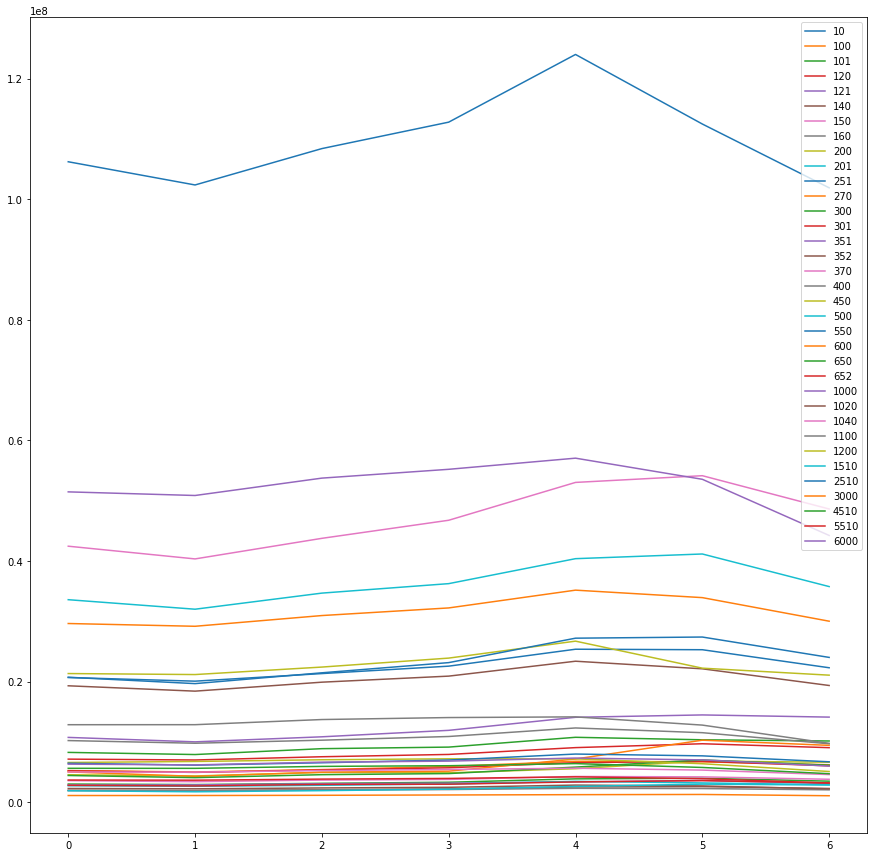

In [48]:
#요일별로 시각화
import seaborn as sns
import matplotlib.pyplot as plt
day_df.plot(figsize=(15,15))

### 2. 각 도로별 특성 확인하기

In [49]:
#상위도로 5개만 살펴보기
road_count = day_df.sum().sort_values(ascending=False)
road_count.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


10      768177275
1000    366142165
150     329139132
500     253824846
100     221091781
dtype: int64

In [50]:
#하위도로 5개만 살펴보기
road_count.tail()

1020    17053857
1510    16131033
140     15516568
160     14559227
3000     8143133
dtype: int64

#### 상위 5개도로
1. 10 - 경부고속도로(서울-부산)
2. 1000 - 서울외곽순환도로(경기도 일산∼퇴계원∼판교∼일산을 원형으로 연결하는 도시순환 고속도로로 총길이 127.5㎞, 왕복 8차선의 도로)
3. 150 - 서해안고속도로(서울특별시 금천구와 전라남도 무안군 사이를 잇는 고속 도로. 길이는 340.8km.)
4. 500 - 영동고속도로(인천-강릉)
5. 100 - 남해고속도로(순천-부산)

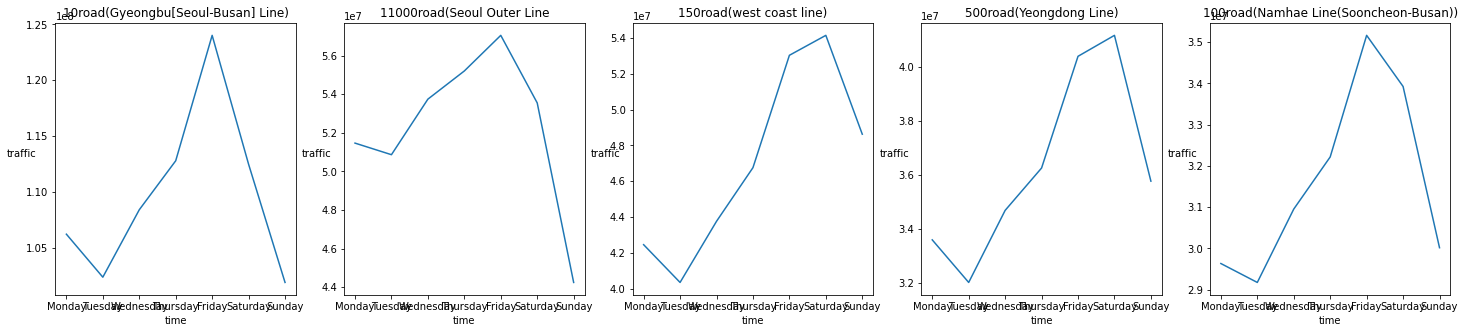

In [51]:
#상위도로 5개 시각화
fig, ax = plt.subplots(1, 5, figsize=(25, 5))

# 1번 그래프(10번도로)
ax[0] = sns.lineplot(x='요일', y='10', data=day_df, ax=ax[0])
ax[0].set_title("10road(Gyeongbu[Seoul-Busan] Line)")
ax[0].set_ylabel('traffic',rotation=0)
ax[0].set_xlabel('time')

# 2번 그래프(1000번도로)
ax[1] = sns.lineplot(x='요일', y='1000', data=day_df, ax=ax[1])
ax[1].set_title("11000road(Seoul Outer Line")
ax[1].set_ylabel('traffic',rotation=0)
ax[1].set_xlabel('time')

# 3번 그래프(150번도로)
ax[2] = sns.lineplot(x='요일', y='150', data=day_df, ax=ax[2])
ax[2].set_title("150road(west coast line)")
ax[2].set_ylabel('traffic',rotation=0)
ax[2].set_xlabel('time')

# 4번 그래프(50번도로)
ax[3] = sns.lineplot(x='요일', y='500', data=day_df, ax=ax[3])
ax[3].set_title("500road(Yeongdong Line)")
ax[3].set_ylabel('traffic',rotation=0)
ax[3].set_xlabel('time')

# 5번 그래프(100번도로)
ax[4] = sns.lineplot(x='요일', y='100', data=day_df, ax=ax[4])
ax[4].set_title("100road(Namhae Line(Sooncheon-Busan))")
ax[4].set_ylabel('traffic',rotation=0)
ax[4].set_xlabel('time')

plt.show()

#### 하위 5개도로
1. 1020 - 남해1지선 고속도로 (경남 함안군-경남 창원시)
2. 1510 - 서천공주고속도로 (충남 서천군 - 충남 공주시)
3. 140 - 고창담양고속도로 (전남 고창군 - 전남 담양군)
4. 160 - 울산고속도로 (울산 내 고속도로)
5. 3000 - 대천남부고속도로 (대천 - 남부)

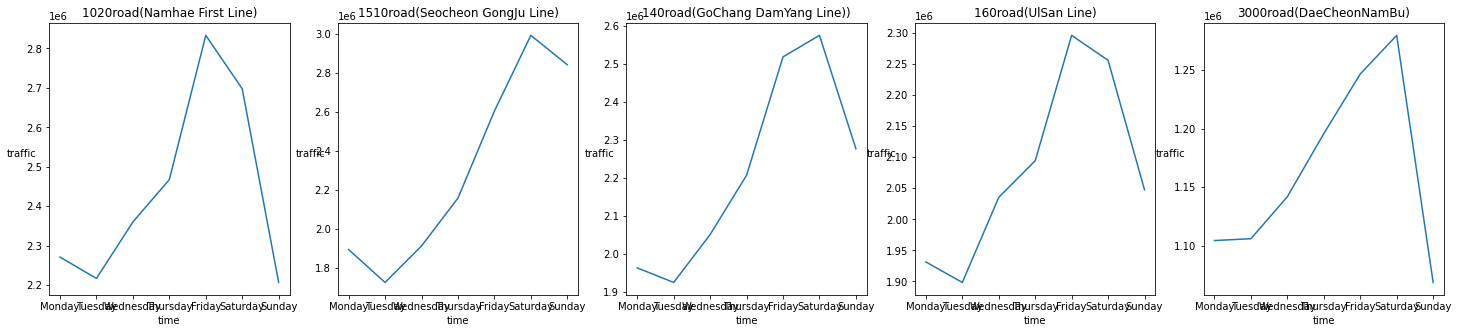

In [52]:
#하위도로 5개 시각화
fig, ax = plt.subplots(1, 5, figsize=(25, 5))

# 1번 그래프(1020번도로)
ax[0] = sns.lineplot(x='요일', y='1020', data=day_df, ax=ax[0])
ax[0].set_title("1020road(Namhae First Line)")
ax[0].set_ylabel('traffic',rotation=0)
ax[0].set_xlabel('time')

# 2번 그래프(1510번도로)
ax[1] = sns.lineplot(x='요일', y='1510', data=day_df, ax=ax[1])
ax[1].set_title("1510road(Seocheon GongJu Line)")
ax[1].set_ylabel('traffic',rotation=0)
ax[1].set_xlabel('time')

# 3번 그래프(140번도로)
ax[2] = sns.lineplot(x='요일', y='140', data=day_df, ax=ax[2])
ax[2].set_title("140road(GoChang DamYang Line))")
ax[2].set_ylabel('traffic',rotation=0)
ax[2].set_xlabel('time')

# 4번 그래프(160번도로)
ax[3] = sns.lineplot(x='요일', y='160', data=day_df, ax=ax[3])
ax[3].set_title("160road(UlSan Line)")
ax[3].set_ylabel('traffic',rotation=0)
ax[3].set_xlabel('time')

# 5번 그래프(3000번도로)
ax[4] = sns.lineplot(x='요일', y='3000', data=day_df, ax=ax[4])
ax[4].set_title("3000road(DaeCheonNamBu)")
ax[4].set_ylabel('traffic',rotation=0)
ax[4].set_xlabel('time')

plt.show()

### 결론
1. 금요일날 (일부는 토요일) 물류통행량이 제일 많음!
2. 서울 및 수도권 지역을 통과하는 도로는 확실히 물류통행량이 많음!
3. 서울외곽순환도로는 평일날 물류통행량이 많음!

### 3. 시간별로 물류교통량 알아보기

In [53]:
#시간 별로 그룹화하기
time_df = train_df4.groupby("시간").sum().reset_index(inplace=False)
time_df = time_df.drop("날짜", axis=1)
time_df

,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,0,11063960,2019977,164454,469055,146516,129822,4053306,136125,316548,222087,1775143,455612,799835,339096,855617,1509190,273963,664262,2841528,2814455,1337651,355067,260275,143953,4347584,108871,384345,1015685,709154,177391,511094,67253,299630,212260,314140
1,1,7860227,1376073,114932,345604,95763,96124,2833127,93286,241803,175967,1253189,356815,608398,241860,643467,1069939,198833,506009,2110322,2042112,924439,241667,182004,99698,2826036,69947,262574,658633,473707,144734,379885,47516,206694,148644,227009
2,2,6237740,1136467,99429,294641,68366,80359,2194343,70947,207319,168480,1005898,329794,534483,209558,544951,870488,157282,463117,1683970,1695713,766473,193943,143000,82811,2065413,51824,205422,511574,347266,121194,321279,39150,170366,124390,191120
3,3,6103505,1314789,103954,313507,66113,81703,2177552,72202,215251,215142,1010474,356798,561892,215926,564501,876715,157969,546589,1671054,1753623,788092,190039,140803,107051,1948371,50240,213163,526691,313009,120050,330289,38465,194162,125919,225262
4,4,8356829,2154521,152371,484542,97057,107754,3267564,112158,275212,260056,1277947,480068,748931,295502,741678,1239554,252937,844287,2183509,2705569,1136426,239472,187094,180710,3116495,75590,327143,872388,449743,152400,442954,59774,314484,200506,370821
5,5,15878740,4016249,304240,818001,249794,189251,7019379,228075,477975,330874,2165185,703761,1118411,534678,1160665,2666202,621033,1636817,3189250,5918345,2187873,400146,338009,338812,9444321,181681,753950,2346313,1238444,226715,728762,112174,645768,447511,798639
6,6,27529965,7317283,623176,1380378,658456,360385,11230734,435682,871499,469755,4045939,1032843,1545243,990769,1885796,4707641,1016513,2622128,4309299,9362658,4362481,696749,686455,696860,16292538,504548,1555479,4212257,2153476,341002,1236446,234545,1542073,938911,1629751
7,7,36911285,11107889,998926,2179561,1174303,628320,14333533,679139,1390594,715503,6764217,1362448,1993743,1618136,2956946,6848371,1242128,3704169,5414289,12221526,7147332,1142394,1164877,1040907,20422681,1043912,2082992,5363780,2694421,475879,2166129,484836,2699995,1520722,2617364
8,8,39531655,11657926,1209520,2820625,1332806,784796,15966576,789318,1642260,882670,7964954,1685319,2530835,1909810,3796282,7575288,1388720,3977611,6211501,13380033,8364451,1615816,1685483,1018016,20977125,1015448,2051459,5218714,2666726,616437,2603584,591715,2632391,1587939,2653211
9,9,41033648,12419900,1348982,3229054,1271112,849283,18058588,830736,1985734,1054322,8775943,2044773,3063212,2211868,4399101,8287948,1548492,4458713,7501776,14168309,9137616,2190198,1947693,1224387,20804857,969652,2039252,5087800,2512521,810075,2661489,451832,2344389,1542060,2680426


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0, flags=flags)


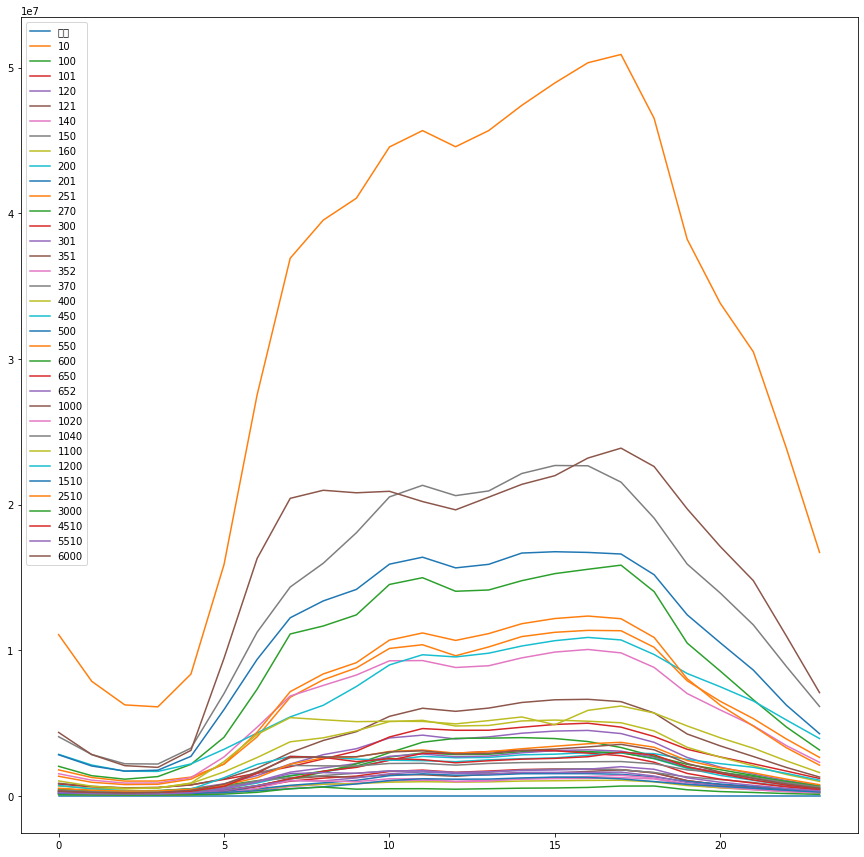

In [54]:
#시간에 따른 도로별 그래프 시각화
time_df.plot(figsize=(15,15))

In [55]:
#상위도로 5개만 살펴보기
road_count2 = time_df.sum().sort_values(ascending=False)
road_count2.head()

10      768177275
1000    366142165
150     329139132
500     253824846
100     221091781
dtype: int64

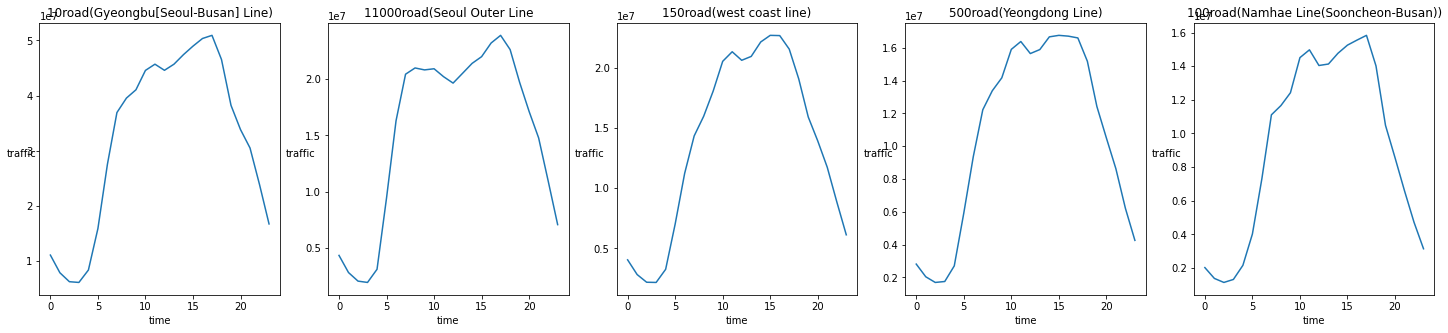

In [56]:
#상위도로 5개 시각화
fig, ax = plt.subplots(1, 5, figsize=(25, 5))

# 1번 그래프(10번도로)
ax[0] = sns.lineplot(x='시간', y='10', data=time_df, ax=ax[0])
ax[0].set_title("10road(Gyeongbu[Seoul-Busan] Line)")
ax[0].set_ylabel('traffic',rotation=0)
ax[0].set_xlabel('time')

# 2번 그래프(1000번도로)
ax[1] = sns.lineplot(x='시간', y='1000', data=time_df, ax=ax[1])
ax[1].set_title("11000road(Seoul Outer Line")
ax[1].set_ylabel('traffic',rotation=0)
ax[1].set_xlabel('time')

# 3번 그래프(150번도로)
ax[2] = sns.lineplot(x='시간', y='150', data=time_df, ax=ax[2])
ax[2].set_title("150road(west coast line)")
ax[2].set_ylabel('traffic',rotation=0)
ax[2].set_xlabel('time')

# 4번 그래프(50번도로)
ax[3] = sns.lineplot(x='시간', y='500', data=time_df, ax=ax[3])
ax[3].set_title("500road(Yeongdong Line)")
ax[3].set_ylabel('traffic',rotation=0)
ax[3].set_xlabel('time')

# 5번 그래프(100번도로)
ax[4] = sns.lineplot(x='시간', y='100', data=time_df, ax=ax[4])
ax[4].set_title("100road(Namhae Line(Sooncheon-Busan))")
ax[4].set_ylabel('traffic',rotation=0)
ax[4].set_xlabel('time')

plt.show()

In [57]:
#하위도로 5개만 살펴보기
road_count2 = time_df.sum().sort_values(ascending=False)
road_count2.tail()

1510    16131033
140     15516568
160     14559227
3000     8143133
시간           276
dtype: int64

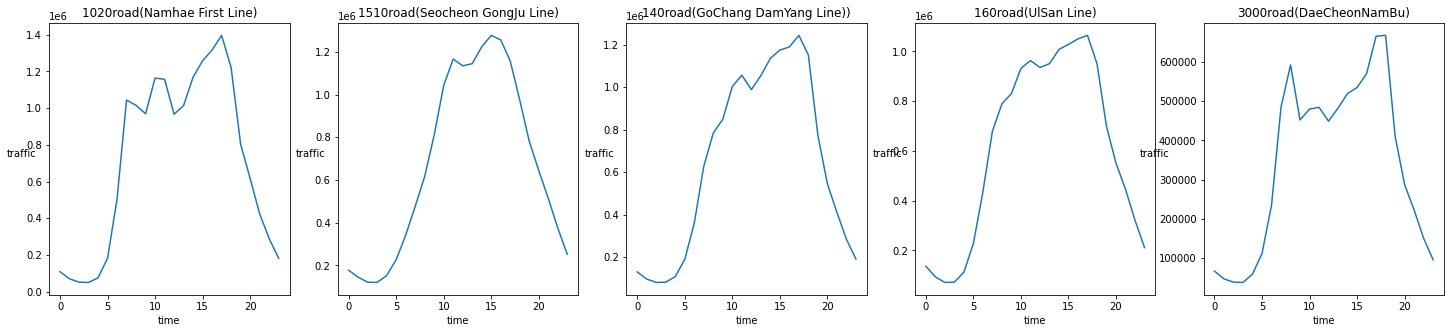

In [58]:
#하위도로 5개 시각화
fig, ax = plt.subplots(1, 5, figsize=(25, 5))

# 1번 그래프(1020번도로)
ax[0] = sns.lineplot(x='시간', y='1020', data=time_df, ax=ax[0])
ax[0].set_title("1020road(Namhae First Line)")
ax[0].set_ylabel('traffic',rotation=0)
ax[0].set_xlabel('time')

# 2번 그래프(1510번도로)
ax[1] = sns.lineplot(x='시간', y='1510', data=time_df, ax=ax[1])
ax[1].set_title("1510road(Seocheon GongJu Line)")
ax[1].set_ylabel('traffic',rotation=0)
ax[1].set_xlabel('time')

# 3번 그래프(140번도로)
ax[2] = sns.lineplot(x='시간', y='140', data=time_df, ax=ax[2])
ax[2].set_title("140road(GoChang DamYang Line))")
ax[2].set_ylabel('traffic',rotation=0)
ax[2].set_xlabel('time')

# 4번 그래프(160번도로)
ax[3] = sns.lineplot(x='시간', y='160', data=time_df, ax=ax[3])
ax[3].set_title("160road(UlSan Line)")
ax[3].set_ylabel('traffic',rotation=0)
ax[3].set_xlabel('time')

# 5번 그래프(3000번도로)
ax[4] = sns.lineplot(x='시간', y='3000', data=time_df, ax=ax[4])
ax[4].set_title("3000road(DaeCheonNamBu)")
ax[4].set_ylabel('traffic',rotation=0)
ax[4].set_xlabel('time')

plt.show()

## Model
1. ProPhet
2. Neural ProPhet

In [59]:
!pip install pystan==2.19.1.1

In [60]:
!pip install fbprophet==0.7.0

     |████████████████████████████████| 64 kB 2.2 MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7-py3-none-any.whl size=6636876 sha256=5a781a8c44c817839ea723665447b213bf5a251dc2570901da5aa468857c076f
  Stored in directory: /root/.cache/pip/wheels/82/e8/a8/53f37f0a409bc51f8693e967dcce8f88bfd33632b40a594a28
Successfully built fbprophet
  Attempting uninstall: fbprophet
    Found existing installation: fbprophet 0.7.1
    Uninstalling fbprophet-0.7.1:
      Successfully uninstalled fbprophet-0.7.1


In [61]:
!pip install plotly

In [62]:
!pip install neuralprophet

     |████████████████████████████████| 67 kB 2.3 MB/s 
     |████████████████████████████████| 172 kB 11.7 MB/s 
  Attempting uninstall: holidays
    Found existing installation: holidays 0.10.5.2
    Uninstalling holidays-0.10.5.2:
      Successfully uninstalled holidays-0.10.5.2


In [63]:
from fbprophet import Prophet
from neuralprophet import NeuralProphet

### Prophet 모델에 맞게 데이터 설정
1. ds와 y가 있어야하므로 날짜를 datetime으로 바꿔줘야함
(위에 작업한 방법 적용!)
2. train, valid, test 데이터를 합치는 과정에서 valid데이터에 이상치가있어서 전 주 데이터를 이용하여 값을 바꿔줌(이상치가 6개만있어서 csv에서 따로 바꿔줌 그래서 인코딩을 이용하여야했음)

In [64]:
#train valid test 합친 데이터 불러오기
fdf = pd.read_csv("/content/drive/MyDrive/모의경진대회/교통 물류 통행량 시계열 예측/data/train/trainvalidtest_not999_2.csv", encoding='cp949')
fdf

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200101,0,83247,19128,2611,5161,1588,892,32263,1636,7938,1894,14957,3527,11174,2930,8640,14175,2035,5231,18492,48520,15393,16628,8804,2790,38657,1311,3482,11299,7072,1176,3810,748,3920,2133,3799
1,20200101,1,89309,19027,3337,5502,1650,1043,35609,1644,9896,1967,14682,3420,13884,3062,8349,15654,2417,5483,15283,57904,15834,19785,8483,3381,45759,1162,3849,13180,8771,1283,3763,782,3483,2057,4010
2,20200101,2,66611,14710,2970,4631,1044,921,26821,1104,9343,1838,11120,3587,17141,3255,7025,12520,1859,5058,14327,53876,13866,24501,8167,2670,27425,768,2299,7986,5426,1536,3229,491,2634,1526,3388
3,20200101,3,53290,13753,2270,4242,1021,790,21322,909,10009,1630,9836,3842,20715,2661,7226,9821,1724,4863,12787,51615,13528,28695,9459,2325,18893,632,1716,5703,3156,1104,2882,431,2488,1268,3686
4,20200101,4,52095,17615,2406,3689,1840,922,22711,1354,15497,1264,10668,4559,28308,2894,8201,9038,960,5166,11479,47424,18156,26977,10944,3583,18135,875,2421,5816,2933,1206,2433,499,2952,1927,5608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3475,20200524,19,314226,98345,10625,28618,8316,6684,141675,6619,23535,8572,67748,16791,33325,19124,42183,63229,13163,35383,73188,100849,84286,26458,15572,10341,139827,8254,16118,23304,14082,8447,21694,2180,15746,10903,21014
3476,20200524,20,300001,87871,8226,22706,6981,5743,142933,6295,20953,7851,61609,14119,30216,18610,35556,59070,12788,30675,68255,95107,76441,24140,13340,8872,142469,5225,15297,21919,14526,7332,19732,1990,14096,10028,17787
3477,20200524,21,304150,71126,6002,18317,4939,3779,133110,4781,15242,6101,48336,11534,25710,15651,27467,53787,12019,26317,61169,86434,61136,21076,9317,6392,138816,4072,12685,21135,14403,5443,16967,1359,11670,7963,14041
3478,20200524,22,236751,44947,3575,11455,3135,2536,98582,3267,8849,4553,33607,8069,18293,9723,16602,38615,8703,17694,47609,58492,37501,12090,5901,3938,100767,2489,8093,14427,10914,3861,11397,859,7270,5194,8230


In [65]:
# 이상치 확인
fdf[fdf < 1].count()

날짜        0
시간      145
10        0
100       0
101       0
120       0
121       0
140       0
150       0
160       0
200       0
201       0
251       0
270       0
300       0
301       0
351       0
352       0
370       0
400       0
450       0
500       0
550       0
600       0
650       0
652       0
1000      0
1020      0
1040      0
1100      0
1200      0
1510      0
2510      0
3000      0
4510      0
5510      0
6000      0
dtype: int64

In [66]:
#위 코드 재작성
start_date = pd.to_datetime('2020-01-01') ## 시작 날짜
end_date = pd.to_datetime('2020-05-24 23:00:00') ## 마지막 날짜
dates2 = pd.date_range(start_date,end_date,freq='h')
dates2

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 01:00:00',
               '2020-01-01 02:00:00', '2020-01-01 03:00:00',
               '2020-01-01 04:00:00', '2020-01-01 05:00:00',
               '2020-01-01 06:00:00', '2020-01-01 07:00:00',
               '2020-01-01 08:00:00', '2020-01-01 09:00:00',
               ...
               '2020-05-24 14:00:00', '2020-05-24 15:00:00',
               '2020-05-24 16:00:00', '2020-05-24 17:00:00',
               '2020-05-24 18:00:00', '2020-05-24 19:00:00',
               '2020-05-24 20:00:00', '2020-05-24 21:00:00',
               '2020-05-24 22:00:00', '2020-05-24 23:00:00'],
              dtype='datetime64[ns]', length=3480, freq='H')

In [67]:
#다시 위에 지정해준 코드를 써서 날짜 새로 생성
date_df2 = dates2.to_frame(index=False)
date_df2.rename(columns={0:"날짜"}, inplace=True)
date_df2

,날짜
0,2020-01-01 00:00:00
1,2020-01-01 01:00:00
2,2020-01-01 02:00:00
3,2020-01-01 03:00:00
4,2020-01-01 04:00:00
...,...
3475,2020-05-24 19:00:00
3476,2020-05-24 20:00:00
3477,2020-05-24 21:00:00
3478,2020-05-24 22:00:00


In [68]:
#datetime 타입으로 변경
fdf2 = fdf.drop(["날짜","시간"], axis=1)
fdf2 = pd.concat([date_df2, fdf2], axis=1)
fdf2

,날짜,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,2020-01-01 00:00:00,83247,19128,2611,5161,1588,892,32263,1636,7938,1894,14957,3527,11174,2930,8640,14175,2035,5231,18492,48520,15393,16628,8804,2790,38657,1311,3482,11299,7072,1176,3810,748,3920,2133,3799
1,2020-01-01 01:00:00,89309,19027,3337,5502,1650,1043,35609,1644,9896,1967,14682,3420,13884,3062,8349,15654,2417,5483,15283,57904,15834,19785,8483,3381,45759,1162,3849,13180,8771,1283,3763,782,3483,2057,4010
2,2020-01-01 02:00:00,66611,14710,2970,4631,1044,921,26821,1104,9343,1838,11120,3587,17141,3255,7025,12520,1859,5058,14327,53876,13866,24501,8167,2670,27425,768,2299,7986,5426,1536,3229,491,2634,1526,3388
3,2020-01-01 03:00:00,53290,13753,2270,4242,1021,790,21322,909,10009,1630,9836,3842,20715,2661,7226,9821,1724,4863,12787,51615,13528,28695,9459,2325,18893,632,1716,5703,3156,1104,2882,431,2488,1268,3686
4,2020-01-01 04:00:00,52095,17615,2406,3689,1840,922,22711,1354,15497,1264,10668,4559,28308,2894,8201,9038,960,5166,11479,47424,18156,26977,10944,3583,18135,875,2421,5816,2933,1206,2433,499,2952,1927,5608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3475,2020-05-24 19:00:00,314226,98345,10625,28618,8316,6684,141675,6619,23535,8572,67748,16791,33325,19124,42183,63229,13163,35383,73188,100849,84286,26458,15572,10341,139827,8254,16118,23304,14082,8447,21694,2180,15746,10903,21014
3476,2020-05-24 20:00:00,300001,87871,8226,22706,6981,5743,142933,6295,20953,7851,61609,14119,30216,18610,35556,59070,12788,30675,68255,95107,76441,24140,13340,8872,142469,5225,15297,21919,14526,7332,19732,1990,14096,10028,17787
3477,2020-05-24 21:00:00,304150,71126,6002,18317,4939,3779,133110,4781,15242,6101,48336,11534,25710,15651,27467,53787,12019,26317,61169,86434,61136,21076,9317,6392,138816,4072,12685,21135,14403,5443,16967,1359,11670,7963,14041
3478,2020-05-24 22:00:00,236751,44947,3575,11455,3135,2536,98582,3267,8849,4553,33607,8069,18293,9723,16602,38615,8703,17694,47609,58492,37501,12090,5901,3938,100767,2489,8093,14427,10914,3861,11397,859,7270,5194,8230


### 1. Prophet 모델 적용시키기

-> **Parameter 설명**
* changepoints : 	트렌드 변화시점을 명시한 리스트값
* changepoint_prior_scale :	changepoint(trend) 의 유연성 조절
* n_changepoints : changepoint 의 개수
* changepoint_range	changepoint : 설정 가능 범위. (기본적으로 데이터 중 80% 범위 내에서 changepoint를 설정합니다.)
* yearly_seasonality: 연 계절성
* weekly_seasonality :주 계절성
* daily_seasonality	: 일 계절성
* seasonality_prior_scale	: 계절성 반영 강도
* seasonality_mode : ‘additive ‘ 인지 ‘multiplicative’ 인지
* holidays : 휴일 또는 이벤트 기간을 명시한 데이터프레임
* holiday_prior_scale	holiday : 반영 강도

In [69]:
#submission 파일 불러오기
submission_file_path = os.path.join(DATASET_PATH2, 'sample_submission.csv')
submission_table = pd.read_csv(submission_file_path)

In [80]:
#Prophet
from sklearn.metrics import mean_squared_error

df = pd.DataFrame()
df['ds'] = fdf2['날짜']
rmse = []

for col in list(fdf.drop(["날짜", "시간"], axis=1).columns):
  df['y'] = fdf2[col]
  model = Prophet()
  model.fit(df)
  df_pred = model.make_future_dataframe(periods=168, freq='h')
  predict = model.predict(df_pred)
  submission_table[col] = list(predict['yhat'][3480:]).copy()
  rmse.append(mean_squared_error(list(df['y']), list(predict['yhat'][:3480]))**0.5)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

In [82]:
# 결과
submission_table

,timestamp,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200525_0,105061.916857,25426.578584,2221.362502,8053.647952,2165.386785,1905.187266,42347.844618,1733.675513,6316.386487,2259.218722,18201.313146,3769.452530,11037.923417,5220.907372,11205.263114,15070.523920,4386.799757,9636.927976,25670.167230,22486.426503,20431.277044,6731.216372,3456.030885,2372.798263,37308.496238,1631.011347,4493.509100,3348.931051,5068.678989,2612.269577,6857.743503,348.258458,3726.613501,3092.987499,4685.102625
1,20200525_1,71638.143705,18635.285763,1632.454239,6608.202593,1605.612168,1578.753843,28784.974972,1287.132224,5181.513209,1781.485490,13641.642438,2484.364416,8581.377646,4110.576137,8676.858914,10579.115884,3421.482613,7875.263130,19159.789650,13789.494489,16193.168011,5095.530225,2492.350615,1702.361604,20875.830567,1206.526382,3231.924692,-218.679670,2796.010306,2084.867807,5575.703273,227.956695,2971.774720,2416.515382,3566.334058
2,20200525_2,51671.849698,14439.922942,1220.113612,5895.067619,900.594924,1258.558258,22367.187349,956.269287,4432.023319,1731.508828,10748.084644,2117.218758,7742.752588,3562.609285,7395.413994,8139.240382,3022.982551,7186.029431,16436.505500,9265.053667,13223.657228,4276.718582,1768.188112,1268.220860,10680.819736,720.694616,2301.639480,-2941.490672,1100.399525,1903.007744,4692.969212,-54.649022,1784.785741,1686.940201,2496.898066
3,20200525_3,56508.666846,16373.806166,1269.704577,6214.014415,603.766914,1161.623005,26150.637590,957.902472,4419.275477,2063.473384,10471.106731,2722.001550,8680.690476,3780.133975,7630.439511,9198.243476,3467.633067,8452.074447,18137.039054,12345.978354,13160.860920,4192.700102,1585.527631,1496.686675,14582.030729,577.824403,2502.949345,-2055.224820,1318.569462,2010.545842,4690.216344,-241.248211,1436.504906,1632.070647,2618.635894
4,20200525_4,90905.343248,26348.699592,1961.960206,7630.431932,1312.954521,1498.871481,40164.969583,1465.499357,5254.787048,2595.200707,14037.649988,3920.152877,10613.701757,4832.790755,9331.225040,14790.291341,4809.521178,12043.253181,23072.297008,24605.648938,17658.702836,4580.067470,2138.890870,2506.122312,37635.583028,1195.254131,4499.947272,4243.691699,4331.616598,2252.802630,6010.916270,5.497781,3385.420861,2888.929174,4853.990916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,20200531_19,298692.580039,89563.064245,8887.564809,24924.469531,9211.189611,6844.910882,128863.553406,6006.857700,18982.140190,7770.176814,63560.594847,14377.618768,28911.225657,17392.869288,36996.767107,53296.970957,11865.864835,28979.603840,64748.292516,90941.452266,71998.717798,21817.422412,13726.531221,8345.376978,144303.036617,6987.951439,14884.053874,26987.478617,17445.980881,7215.671724,21335.180945,2860.177120,16439.679397,10822.780293,18896.020299
164,20200531_20,256177.752066,69675.246398,6339.259973,19207.333132,6550.462521,4988.612529,108810.171466,4689.152532,14787.711223,6140.723881,51237.078526,11100.779193,23796.746681,13504.034496,29177.602854,42845.820689,10012.585701,22845.775548,56497.144073,73352.882268,56162.120215,17859.335742,9944.367187,5980.910451,122714.893292,4904.857695,12367.750957,19985.287119,14910.344432,5905.355669,16845.801584,1795.146709,12027.357633,7980.300834,13663.337221
165,20200531_21,215037.139240,52935.139518,4446.615999,14932.837730,4356.562904,3496.128888,90705.287774,3570.628269,11452.414278,4832.604229,40093.753106,8560.192739,19961.528227,10362.070940,22708.093142,33276.279876,8350.597410,17868.805669,49057.714627,56516.918503,42550.009659,14421.710898,7134.999627,4300.484621,98017.208769,3267.187838,9731.472593,12836.832172,11978.414142,4868.263809,13043.559300,832.994708,7859.380784,5613.198995,9344.716028
166,20200531_22,177547.809569,41308.167845,3307.252912,12075.805665,3061.263032,2589.591808,74078.100277,2

In [81]:
#rmse
rmse

[38485.9242725521,
 13732.43826158354,
 2468.859716205696,
 6019.115671399162,
 1834.5775814593694,
 1579.471923255832,
 20200.391129917483,
 982.6252398153994,
 3841.013155705775,
 1792.4501894819869,
 10502.37113415029,
 3858.411969602253,
 6552.370627652699,
 4032.939628966036,
 8985.615616786408,
 9104.938359868307,
 1700.2056280804327,
 5446.590056352243,
 9426.62013327791,
 14780.141305448773,
 16681.848709443875,
 6018.26716253313,
 4116.318074109818,
 2074.4608331160407,
 20190.47291059027,
 1718.5702047095954,
 1985.6776230374342,
 6120.72132227786,
 2800.404894979011,
 2209.980821011556,
 3801.8995413507487,
 906.1253920970424,
 2982.090113702628,
 1891.1640151695926,
 3203.759293362012]

#### Prophet 기본 모델 시각화

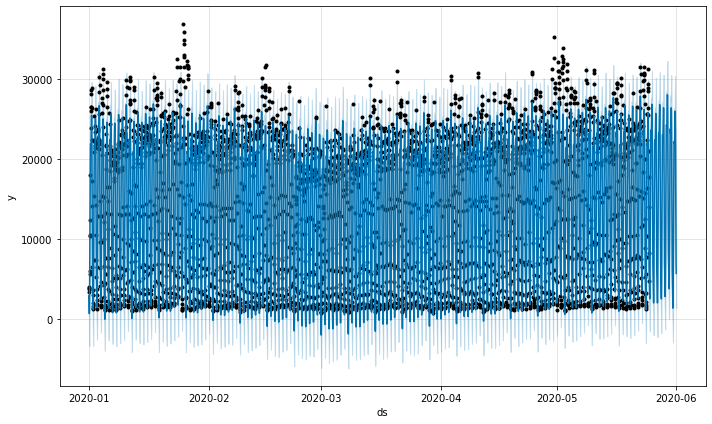

In [83]:
# 예측한 결과 시각화
fig1 = model.plot(predict)

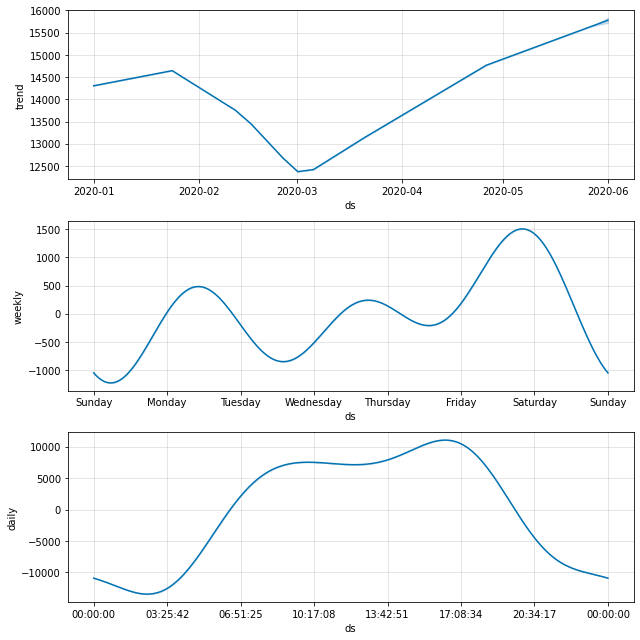

In [84]:
#모델의 컴포턴트 시각화
# trend : 추세성, weekly : 주 계절성, daily : 일 계절성
fig2 = model.plot_components(predict)

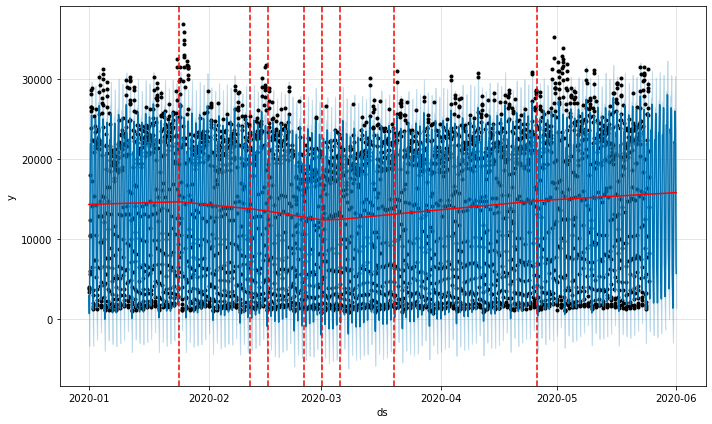

In [85]:
#Trend 확인
#빨간점 : 추세선, 검은점 : 실제값
from fbprophet.plot import add_changepoints_to_plot

fig = model.plot(predict)
a = add_changepoints_to_plot(fig.gca(), model, predict)

####최적의 Parameter 조절

In [87]:
#holiday 설정
holiday = pd.DataFrame({
    'holiday': 'holiday',
    'ds': pd.concat([
        pd.Series(pd.date_range('2020-01-01', '2020-01-02', freq='h')),
        pd.Series(pd.date_range('2020-01-24', '2020-01-28', freq='h')),
        pd.Series(pd.date_range('2020-03-01', '2020-03-02', freq='h')),
        pd.Series(pd.date_range('2020-04-15', '2020-04-16', freq='h')),
        pd.Series(pd.date_range('2020-04-30', '2020-05-01', freq='h')),
        pd.Series(pd.date_range('2020-05-05', '2020-05-06', freq='h')),
    ])
    # lower_window = 0,
    # upper_window = 1
})
holiday = holiday.reset_index(drop=True)
holiday

,holiday,ds
0,holiday,2020-01-01 00:00:00
1,holiday,2020-01-01 01:00:00
2,holiday,2020-01-01 02:00:00
3,holiday,2020-01-01 03:00:00
4,holiday,2020-01-01 04:00:00
...,...,...
217,holiday,2020-05-05 20:00:00
218,holiday,2020-05-05 21:00:00
219,holiday,2020-05-05 22:00:00
220,holiday,2020-05-05 23:00:00


In [88]:
# # # 최적의 매개변수 찾기 - 교차 검증 및 rmse
# from fbprophet.diagnostics import cross_validation
# from fbprophet.diagnostics import performance_metrics
# from fbprophet.plot import plot_cross_validation_metric
# from tqdm import tqdm
# import itertools
# import numpy as np
# import pandas as pd

# df = pd.DataFrame()
# df['ds'] = fdf2['날짜']
# df['y'] = fdf2['3000']
# df['cap'] = 500000
# df['floor'] = 0

# param_grid = {  
#     'changepoint_prior_scale': [0.01, 0.1,0.3, 0.5],
#     'seasonality_prior_scale': [0.1, 1.0, 10.0],
#     'seasonality_mode' : ['multiplicative', 'additive'],
#     # 'holidays_prior_scale' : [0.1, 1, 5, 10],
#     'weekly_seasonality' : [1,5,10],
#     'daily_seasonality' : [1,5,10]
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params).fit(df)  # Fit model with given params
#     df_cv = cross_validation(model, initial='1 days', period='7 days', horizon = '7 days')
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

# best_params = all_params[np.argmin(rmses)]
# print(best_params)

# fig1 = plot_cross_validation_metric(df_cv, metric='rmse')

In [201]:
# 최적 parameter 조절한 Prophet
from sklearn.metrics import mean_squared_error

df = pd.DataFrame()
df['ds'] = fdf2['날짜']
rmse2 = []

for col in list(fdf.drop(["날짜", "시간"], axis=1).columns):
  df['y'] = fdf2[col]
  model = Prophet(changepoint_prior_scale = 0.3,
                  daily_seasonality=10,
                  weekly_seasonality=90,
                  yearly_seasonality = False,
                  seasonality_mode = 'multiplicative',
                  holidays=holiday,
                  holidays_prior_scale=10
                  )
  model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

  model.fit(df)
  df_pred = model.make_future_dataframe(periods=168, freq='h')
  predict = model.predict(df_pred)
  submission_table[col] = list(predict['yhat'][3480:]).copy()
  rmse2.append(mean_squared_error(list(df['y']), list(predict['yhat'][:3480]))**0.5)


In [202]:
# 결과
submission_table

,timestamp,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200525_0,86700.537691,14252.750098,609.697562,1170.643583,776.309692,559.232242,32528.032439,950.363941,1815.907688,1112.687266,11180.543267,2323.128493,5630.537525,2392.138014,3978.157979,15057.607568,3264.255144,6984.521599,20659.800000,18044.375840,7335.952310,2115.782602,870.689921,631.591511,30958.733080,574.631058,2647.799586,5023.514836,4206.863448,1406.678150,3801.825423,258.639506,2664.824479,1557.875657,2559.285984
1,20200525_1,57824.346430,8690.862223,179.876100,-98.320517,415.373467,282.068308,20452.089689,580.124729,959.703282,706.266053,6705.581073,1398.218131,3412.975916,1291.982875,1888.769200,10787.970789,2252.930683,4934.693028,13995.394737,11317.345260,2327.378510,1004.321145,254.924986,207.099923,19960.853290,274.838468,1706.459256,3150.021148,2725.066485,840.183684,2382.103103,150.835214,1887.273626,1043.576204,1807.317306
2,20200525_2,46583.674136,7620.019774,28.545465,-311.882923,225.957316,233.402837,15132.220563,458.608398,628.948612,738.788115,5312.291835,1244.709590,2542.673221,952.943347,1071.931165,8680.318318,1764.343980,4388.889748,10662.159133,9107.064775,376.732901,520.002120,26.135402,114.335431,16177.123142,194.141315,1418.600080,2727.637098,2198.251413,589.147332,1872.491494,108.071317,1639.614614,940.293539,1535.268027
3,20200525_3,49121.270901,9620.161372,79.847047,21.652467,237.863378,340.243674,16109.215229,501.903527,866.367136,1187.286665,6266.706446,1602.556760,2764.411535,1052.159411,1531.379281,9068.271044,1876.090787,5565.876566,11183.798787,10334.079894,779.342051,537.718384,45.660751,433.172975,17402.491817,231.126022,1656.410633,3167.860013,2228.252443,695.728786,2318.633825,169.178025,1970.037568,1046.347085,2038.818271
4,20200525_4,80941.970600,18743.536818,608.351437,1913.346794,572.162845,699.453834,32123.953160,929.306567,1503.091155,1726.913427,10187.121195,2795.174895,4935.097618,2229.396964,3594.458989,14552.278197,3318.232455,9790.261595,16852.014796,20636.065487,4978.364866,1135.239458,507.968158,1179.315620,33358.624078,522.492391,3039.362028,6571.759457,3968.463269,1202.085684,4027.174353,334.657679,3283.916435,1963.482936,3737.504087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,20200531_19,309790.225124,94322.488628,9809.850867,27368.789932,8652.170641,7072.943728,150430.654228,6491.062605,23082.207489,8658.512770,67976.291033,15960.040532,33778.941433,20051.503089,41744.372690,56834.164592,13510.323407,35379.597300,73112.018066,96934.695299,83363.558533,26640.994929,15037.534372,9584.320811,124663.359861,7015.982442,15179.041491,18899.274566,13534.673678,9348.858574,22789.106779,2146.587487,14344.394547,10545.479703,19185.238585
164,20200531_20,297007.118003,85374.707674,8330.525512,22213.309407,7093.488661,5752.738899,145139.046363,5910.274565,18583.552236,7709.734117,62399.782852,14068.341303,29864.580957,18156.199227,37032.160514,53875.758067,13019.232628,32010.973997,68845.971314,90326.723864,74659.047043,23551.216725,12620.152202,8036.274069,126192.919455,5407.133746,14225.477358,18481.249487,13774.317841,8626.823662,20751.096504,1754.584881,12278.725562,9517.421852,16746.138636
165,20200531_21,284678.294711,68290.838851,6353.829870,17014.778168,5105.113128,4246.724476,128690.569147,4723.841037,13542.660327,6323.804447,49946.374450,11826.104374,25589.250764,14855.174418,29535.611414,47131.810613,11496.792094,26531.055641,61322.683709,78475.282831,59395.170895,18805.917205,9727.693564,6012.147322,115153.870826,4070.126400,11686.775533,16427.196654,12652.668715,7145.821328,17487.422145,1280.801019,9019.295930,7495.368167,13027.290060
166,20200531_22,221235.584140,46682.201847,4390.308036,11515.099922,3403.396731,2849.211806,98398.863026,3265.192945,9092.224842,4686.386105,34620.327728,8970.11331

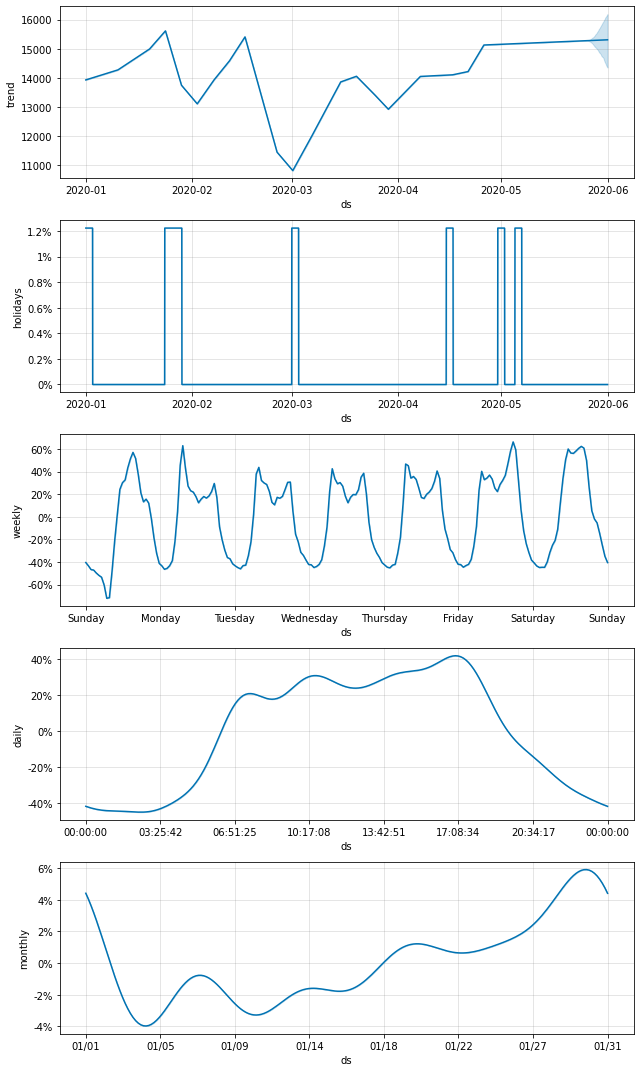

In [204]:
#모델의 컴포턴트 시각화
fig2 = model.plot_components(predict)

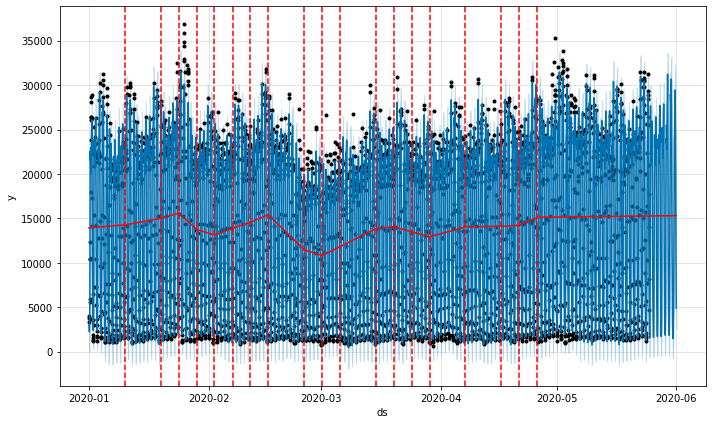

In [205]:
#추세선 확인해보기
fig1 = model.plot(predict)
a2 = add_changepoints_to_plot(fig1.gca(), model, predict)

In [206]:
#각 도로별 rmse 확인
rmse2

[23551.918644810696,
 7981.960875115388,
 1535.799948258872,
 3630.408350827433,
 1068.5256829956852,
 959.4868003911638,
 12614.795771056268,
 571.2559719894435,
 2076.690687586371,
 1163.1433570097176,
 6149.28512312898,
 2446.2926407621317,
 3982.0429564243327,
 2438.3753487783933,
 5446.419969911667,
 5811.862181154856,
 1088.0442989189282,
 3431.117562268281,
 6278.818793232466,
 8679.615455250641,
 10331.757163106193,
 3307.994869229316,
 2317.391854387274,
 1245.774093362331,
 11414.165330521435,
 1094.4889994663554,
 1112.7445861153474,
 3462.7588070155493,
 1602.6409397293435,
 1366.2736469339436,
 2251.589186087997,
 519.8146426762169,
 1766.7772679114123,
 1054.3908000910317,
 1752.5734983070242]

In [240]:
#Rmse 평균
sum(rmse2) /35

4157.342745851786

### 2. Neural Prophet 모델 적용시키기

In [228]:
# #submission 파일 불러오기
# submission_file_path = os.path.join(DATASET_PATH2, 'sample_submission.csv')
# submission_table2 = pd.read_csv(submission_file_path)

In [231]:
# #Neural Prophet
# df = pd.DataFrame()
# df['ds'] = fdf2['날짜']
# model2 = NeuralProphet(changepoints=None,
#                   daily_seasonality=10,
#                   weekly_seasonality=90,
#                   seasonality_mode = 'multiplicative',
#                   yearly_seasonality = False
#                   # holidays=holiday,
#                   # holidays_prior_scale=10
#                   )

# for col in list(fdf.drop(["날짜", "시간"], axis=1).columns):
#   df['y'] = fdf2[col]
#   loss = model2.fit(df, freq="H") #NeuralProphet
#   df_pred = model2.make_future_dataframe(df, periods=168)
#   predict = model2.predict(df_pred)
#   submission_table2[col] = list(predict['yhat1']).copy()

INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 132
INFO:NP.config:Auto-set epochs to 132


  0%|          | 0/277 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.24E-02, min: 2.46E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.24E-02, min: 2.46E-01


  0%|          | 0/277 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.19E+00, min: 1.82E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.19E+00, min: 1.82E-01


  0%|          | 0/277 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.87E-02, min: 3.08E-01
INFO:NP.utils_torch:lr-range-test results: steep: 6.87E-02, min: 3.08E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.38E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.38E-01
Epoch[132/132]: 100%|██████████| 132/132 [00:29<00:00,  4.43it/s, SmoothL1Loss=0.00212, MAE=1.53e+4, RMSE=2.32e+4, RegLoss=0]
WARNING - (NP.forecaster.fit) - Model has already been fitted. Re-fitting will produce different results.
Epoch[132/132]: 100%|██████████| 132/132 [00:28<00:00,  4.63it/s, SmoothL1Loss=0.000255, MAE=5.29e+3, RMSE=8.16e+3, RegLoss=0]
WARNING - (NP.forecaster.fit) - Model has already been fitted. Re-fitting will produce different results.
Epoch[132/132]: 100%|██████████| 132/132 [00:28<00:00,  4.61it/s, SmoothL1Loss=1.82e-5, MAE=1.27e+3, RMSE=2.08e+3, RegLoss=0]
WARNING - (NP.forecaster.fit) - Model has already been fitted. Re-fitting will produ

In [232]:
# #결과
# submission_table2

,timestamp,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200525_0,78617.649699,13549.012041,1273.774749,20041.370167,1492.242306,1114.255243,32202.728356,1179.283973,5589.391865,1360.841885,12577.312652,883.596737,17954.788772,6451.644687,12555.694186,13030.702941,4766.755752,5586.211311,19717.370171,20002.241832,12438.179975,5562.689022,1115.489698,1438.511096,26860.609652,887.229643,5157.811693,14323.779197,5901.352489,1276.781972,10443.649248,-71.176807,7091.556779,2906.916622,6556.539553
1,20200525_1,51110.494410,8061.667300,852.756497,19959.489663,1154.482134,877.861312,19558.610221,819.939155,4986.914344,1019.292386,8244.789420,75.882594,17302.110075,5877.487765,11111.438042,9265.820511,4082.274334,3420.395001,13466.861588,13712.117950,7950.515607,5078.478222,686.775830,1044.743864,15755.372312,594.300202,4380.116229,13484.183418,4672.076143,884.660680,9989.855224,-199.822252,6769.900187,2489.655284,6073.494157
2,20200525_2,40850.030233,7072.992744,793.652025,20027.277949,963.751769,859.610823,15439.808376,705.022091,4785.064018,1069.005980,6930.280711,92.199667,16676.260696,5612.767598,10544.362326,7117.104786,3731.469240,2719.954445,10197.415609,11777.952219,5981.587845,5016.001545,435.020260,972.104070,11306.644011,560.487969,4180.433246,13319.490756,4288.869420,747.505104,9658.908512,-249.541482,6428.881955,2462.725560,5901.228479
3,20200525_3,42726.920627,8985.203211,856.989719,20096.971115,989.351212,955.035896,16034.691743,760.093446,4977.792622,1542.588629,7810.762884,273.306637,16438.558679,5724.380098,10795.051136,7214.767662,3829.987497,3517.333550,10556.050193,12764.259327,6460.872099,4905.875746,418.401619,1268.374713,12905.753815,604.614103,4411.975318,13543.747288,4395.425728,811.257102,9972.330471,-178.379935,6773.296347,2508.324304,6282.149487
4,20200525_4,72984.284135,17942.161677,1281.060289,19860.399360,1299.365737,1304.757319,30627.732702,1159.425592,5289.455905,2039.662565,11417.587144,1813.760093,16735.786870,6426.865396,11871.980779,12281.013826,4711.275731,7494.168122,15619.582246,22467.465653,9826.329376,4875.259567,838.733593,1940.490441,28882.235684,861.571014,5369.450289,15011.921705,5778.625664,1259.822306,10689.944890,33.581367,7476.064894,3248.897334,7496.233298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,20200531_19,286289.113208,86264.744165,8292.291986,18819.568909,8019.759944,6210.241066,124620.967624,5864.358292,18775.492878,7413.939811,59670.550184,13176.905550,20754.964592,15701.798579,25332.809361,49599.555141,11735.528392,31821.273263,63235.157768,82536.187973,66478.130603,20196.946832,11915.915263,8534.741230,126431.219988,6016.719085,14272.957975,18237.675757,14178.062760,6499.696840,18129.661109,2165.816552,15170.740136,9653.959418,16940.144330
164,20200531_20,274385.944358,78099.742219,6703.808924,18843.559877,6496.824900,4958.108981,119490.538248,5334.781265,15137.007170,6449.253283,54775.445160,10358.590920,20340.906003,14292.267475,23784.410156,47202.206623,11394.422086,28776.146525,59259.279335,76823.535440,59414.116085,16985.711895,8814.501739,7106.163793,127267.357602,4576.559472,13528.975397,18246.607634,14363.060870,5761.809736,17088.373010,1658.810608,14073.278868,8815.000595,15144.271924
165,20200531_21,262174.353375,61480.825095,4617.700931,18865.595079,4625.234489,3485.532238,104751.752667,4225.469721,11409.796407,4927.993067,43967.790423,7039.875243,19877.296934,11723.424813,21413.875455,41736.949611,10284.341825,23861.795063,52744.439524,66420.404324,47044.979878,12093.400601,5294.392317,5095.257511,116754.545992,3359.908108,11639.403654,18419.086783,13365.231828,4271.939347,15174.508324,986.938670,12261.058210,7211.761848,12734.276582
166,20200531_22,203052.418689,40710.753818,2533.548901,18869.975244,3036.893756,2099.938078,78903.970013,2869.481347,

In [207]:
#따로 쓰기 위해 valid 데이터 저장
submission_table.to_csv('/content/drive/MyDrive/모의경진대회/교통 물류 통행량 시계열 예측/data2/prophet16.csv', index=False)

In [233]:
# #따로 쓰기 위해 valid 데이터 저장
# submission_table2.to_csv('/content/drive/MyDrive/모의경진대회/교통 물류 통행량 시계열 예측/data2/neuralprophet1.csv', index=False)